<a href="https://colab.research.google.com/github/ksdtt/ml-pet-projects/blob/main/kNN_products.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Задание 3. Классификация: KNN (продукты)**


1. Загрузите [набор данных о еде](https://school.sgu.ru/pluginfile.php/117390/mod_assign/intro/ABBREV_with_CLASS.xlsx) с метками классов из этого задания ([источник оригинального набора:](https://www.ars.usda.gov/northeast-area/beltsville-md-bhnrc/beltsville-human-nutrition-research-center/methods-and-application-of-food-composition-laboratory/mafcl-site-pages/sr11-sr28/), SR28ABXL.Zip (2.9 MB)-Excel file format).
2. Изучите полученный набор данных: все ли столбцы информативны, есть ли зависимости и т. д.
3. Преобразуйте набор данных, подготовив его к применению классификации **методом k-ближайших соседей:**
 - выполните минимальные необходимые манипуляции (обработайте категориальные признаки и пропуски), а также
 - отделите столбец с меткой CLASS и 
 - разбейте данные на тренировочный и тестовый наборы.
4. Обучите классификатор KNeighborsClassifier на тренировочном наборе.
5. Используйте обученную модель на тестовых данных, оцените полученные результаты. Используйте визуализацию и несколько метрик.
6. Нормализуйте данные двумя способами (например, примените StandardScaler и MinMaxScaler).
7. Обучите ещё две модели на нормализованных данных. Оцените и сравните полученные результаты между собой и с результатами без нормализации.
8. Подберите значения гиперпараметров (количество соседей и метрику расстояния) с помощью GridSearchCV.
9. Сделайте выводы об использовании (плюсах и минусах) метода k-ближайших соседей для классификации в целом и применительно к рассмотренному набору данных.
10. Проведите предварительный отбор признаков и оцените результаты предсказаний, если:
 - оставить только по одному из сильно коррелирующих признаков,
 - объединить группу связанных по смыслу признаков в один (например, для витамина A),
 - повторно выбирать случайным образом поднабор из нескольких признаков и запоминать лучшие результаты (например, выбирать по 5 или по 7 признаков с помощью random.sample, повторять выбор 100 раз),
 - использовать методы уменьшения размерности (например, PCA),
 - свой вариант отбора и подготовки признаков.

## **Чтение данных**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import plotly.graph_objs as go
import plotly.express as px

import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

excel_data = pd.read_excel('/content/drive/MyDrive/python/ABBREV_with_CLASS.xlsx')

data = pd.DataFrame(excel_data, columns=excel_data.columns.ravel())
data.shape

Mounted at /content/drive


(8790, 55)

## **Описание датасета**

In [ ]:
data.head()

,Unnamed: 0,NDB_No,Shrt_Desc,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),Magnesium_(mg),Phosphorus_(mg),Potassium_(mg),Sodium_(mg),Zinc_(mg),Copper_mg),Manganese_(mg),Selenium_(µg),Vit_C_(mg),Thiamin_(mg),Riboflavin_(mg),Niacin_(mg),Panto_Acid_mg),Vit_B6_(mg),Folate_Tot_(µg),Folic_Acid_(µg),Food_Folate_(µg),Folate_DFE_(µg),Choline_Tot_ (mg),Vit_B12_(µg),Vit_A_IU,Vit_A_RAE,Retinol_(µg),Alpha_Carot_(µg),Beta_Carot_(µg),Beta_Crypt_(µg),Lycopene_(µg),Lut+Zea_ (µg),Vit_E_(mg),Vit_D_µg,Vit_D_IU,Vit_K_(µg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,GmWt_Desc1,GmWt_2,GmWt_Desc2,Refuse_Pct,CLASS
0,0,1001,"BUTTER,WITH SALT",15.87,717,0.85,81.11,2.11,0.06,0.0,0.06,24.0,0.02,2.0,24.0,24.0,643.0,0.09,0.000,0.000,1.0,0.0,0.005,0.034,0.042,0.110,0.003,3.0,0.0,3.0,3.0,18.8,0.17,2499.0,684.0,671.0,0.0,158.0,0.0,0.0,0.0,2.32,0.0,0.0,7.0,51.368,21.021,3.043,215.0,5.00,"1 pat, (1"" sq, 1/3"" high)",14.2,1 tbsp,0.0,10
1,1,1002,"BUTTER,WHIPPED,W/ SALT",16.72,718,0.49,78.30,1.62,2.87,0.0,0.06,23.0,0.05,1.0,24.0,41.0,583.0,0.05,0.010,0.001,0.0,0.0,0.007,0.064,0.022,0.097,0.008,4.0,0.0,4.0,4.0,18.8,0.07,2468.0,683.0,671.0,1.0,135.0,6.0,0.0,13.0,1.37,0.0,0.0,4.6,45.390,19.874,3.331,225.0,3.80,"1 pat, (1"" sq, 1/3"" high)",9.4,1 tbsp,0.0,10
2,2,1003,"BUTTER OIL,ANHYDROUS",0.24,876,0.28,99.48,0.00,0.00,0.0,0.00,4.0,0.00,0.0,3.0,5.0,2.0,0.01,0.001,0.000,0.0,0.0,0.001,0.005,0.003,0.010,0.001,0.0,0.0,0.0,0.0,22.3,0.01,3069.0,840.0,824.0,0.0,193.0,0.0,0.0,0.0,2.80,0.0,0.0,8.6,61.924,28.732,3.694,256.0,12.80,1 tbsp,205.0,1 cup,0.0,0
3,3,1004,"CHEESE,BLUE",42.41,353,21.40,28.74,5.11,2.34,0.0,0.50,528.0,0.31,23.0,387.0,256.0,1146.0,2.66,0.040,0.009,14.5,0.0,0.029,0.382,1.016,1.729,0.166,36.0,0.0,36.0,36.0,15.4,1.22,721.0,198.0,192.0,0.0,74.0,0.0,0.0,0.0,0.25,0.5,21.0,2.4,18.669,7.778,0.800,75.0,28.35,1 oz,17.0,1 cubic inch,0.0,10
4,4,1005,"CHEESE,BRICK",41.11,371,23.24,29.68,3.18,2.79,0.0,0.51,674.0,0.43,24.0,451.0,136.0,560.0,2.60,0.024,0.012,14.5,0.0,0.014,0.351,0.118,0.288,0.065,20.0,0.0,20.0,20.0,15.4,1.26,1080.0,292.0,286.0,0.0,76.0,0.0,0.0,0.0,0.26,0.5,22.0,2.5,18.764,8.598,0.784,94.0,132.00,"1 cup, diced",113.0,"1 cup, shredded",0.0,10


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 55 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         8790 non-null   int64  
 1   NDB_No             8790 non-null   int64  
 2   Shrt_Desc          8790 non-null   object 
 3   Water_(g)          8789 non-null   float64
 4   Energ_Kcal         8790 non-null   int64  
 5   Protein_(g)        8790 non-null   float64
 6   Lipid_Tot_(g)      8790 non-null   float64
 7   Ash_(g)            8465 non-null   float64
 8   Carbohydrt_(g)     8790 non-null   float64
 9   Fiber_TD_(g)       8196 non-null   float64
 10  Sugar_Tot_(g)      6958 non-null   float64
 11  Calcium_(mg)       8442 non-null   float64
 12  Iron_(mg)          8646 non-null   float64
 13  Magnesium_(mg)     8051 non-null   float64
 14  Phosphorus_(mg)    8211 non-null   float64
 15  Potassium_(mg)     8364 non-null   float64
 16  Sodium_(mg)        8707 

**Описание датасета:**

8790 строк и 55 столбцов, 3 категориальных признака, остальные числовые

* NDB_No -> 
* Shrt_Desc -> короткое описание
* Water_(g) -> вода
* Energ_Kcal -> энергетическая ценность ккал
* Protein_(g) -> белок 
* Lipid_Tot_(g) -> общий жир
* Ash_(g) -> зола
* Carbohydrt_(g) -> углеводы, по разности
* Fiber_TD_(g) -> пищевые волокна, общее значение
* Sugar_Tot_(g) -> сахар всего
* Calcium_(mg) -> кальций
* Iron_(mg) -> железо
* Magnesium_(mg) -> магний
* Phosphorus_(mg) ->  фосфор
* Potassium_(mg) -> калий
* Sodium_(mg) ->  натрий
* Zinc_(mg) ->  цинк
* Copper_mg) ->  медь
* Manganese_(mg) ->  марганец
* Selenium_(µg) -> селен
* Vit_C_(mg) -> витамин С
* Thiamin_(mg) -> тиамин
* Riboflavin_(mg) -> рибофлавин
* Niacin_(mg) -> ниацин
* Panto_Acid_mg) -> пантатеновая кислота
* Vit_B6_(mg) ->  витамин В-6
* Folate_Tot_(µg) -> фолаты общие
* Folic_Acid_(µg) ->  фолиевая кислота
* Food_Folate_(µg) -> фолаты пищевые
* Folate_DFE_(µg) ->  фолаты DFE
* Choline_Tot_ (mg) -> холин общий
* Vit_B12_(µg) -> витамин В12
* Vit_A_IU -> витамин А, IU
* Vit_A_RAE -> витамин А, RAE
* Retinol_(µg) -> рентинол
* Alpha_Carot_(µg) -> альфа-каротин
* Beta_Carot_(µg) ->  бета-каротин
* Beta_Crypt_(µg) ->  криптоксантин бета
* Lycopene_(µg) -> ликопен
* Lut+Zea_ (µg) -> лютеин + гексаксантин
* Vit_E_(mg) -> витамин Е
* Vit_D_µg -> витамин Д
* Vit_D_IU -> витамин Д, IU
* Vit_K_(µg) -> витамин K (филлохинон)
* FA_Sat_(g) -> жирные кислоты насыщенные, всего
* FA_Mono_(g) -> жирные кислоты, мононенасыщенные
* FA_Poly_(g) -> жирные кислоты, общие полиненасыщенные
* Cholestrl_(mg) -> холестерин
* GmWt_1 -> Вес первой единицы измерения для домохозяйств
* GmWt_Desc1 -> Описание первой единицы измерения для домохозяйств
* GmWt_2 -> Вес второй единицы измерения для домохозяйств
* GmWt_Desc2 -> Описание второй единицы измерения для домохозяйств
* Refuse_Pct -> процент потерь
* CLASS -> метка класса

## **Изучение набора данных (информативность столбцов, зависимость признаков, ...)**

In [ ]:
data.describe()

,Unnamed: 0,NDB_No,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),Magnesium_(mg),Phosphorus_(mg),Potassium_(mg),Sodium_(mg),Zinc_(mg),Copper_mg),Manganese_(mg),Selenium_(µg),Vit_C_(mg),Thiamin_(mg),Riboflavin_(mg),Niacin_(mg),Panto_Acid_mg),Vit_B6_(mg),Folate_Tot_(µg),Folic_Acid_(µg),Food_Folate_(µg),Folate_DFE_(µg),Choline_Tot_ (mg),Vit_B12_(µg),Vit_A_IU,Vit_A_RAE,Retinol_(µg),Alpha_Carot_(µg),Beta_Carot_(µg),Beta_Crypt_(µg),Lycopene_(µg),Lut+Zea_ (µg),Vit_E_(mg),Vit_D_µg,Vit_D_IU,Vit_K_(µg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,GmWt_2,Refuse_Pct,CLASS
count,8790.000000,8790.000000,8789.000000,8790.000000,8790.000000,8790.000000,8465.000000,8790.000000,8196.000000,6958.000000,8442.000000,8646.000000,8051.000000,8211.000000,8364.000000,8707.000000,8084.000000,7533.000000,6630.000000,7090.000000,7972.000000,8156.000000,8174.000000,8153.000000,6548.000000,7885.000000,7529.000000,6751.000000,7022.000000,6733.000000,4774.000000,7597.000000,8079.000000,7255.000000,6984.000000,5532.000000,5628.000000,5520.000000,5498.000000,5475.000000,5901.000000,5528.000000,5579.000000,5227.000000,8441.000000,8124.000000,8125.000000,8380.000000,8490.000000,4825.000000,8740.000000,8790.000000
mean,4394.500000,15663.495222,54.112218,226.317634,11.342849,10.553725,1.783468,22.127710,2.187445,8.543066,76.738214,2.699674,35.295988,165.142126,279.472740,312.495923,2.117438,0.195984,0.658156,15.591016,9.231134,0.223134,0.252237,3.657721,0.650989,0.291531,51.598220,23.169012,24.556109,64.275806,43.596230,1.392472,735.810744,111.726120,89.770046,31.496927,221.314499,10.623913,157.039651,193.970046,1.331518,0.579269,22.990142,15.631586,3.576334,4.081006,2.288767,40.613246,96.395130,250.747668,4.964416,5.715586
std,2537.598767,9251.413586,30.772854,169.877539,10.530474,15.814842,3.004609,27.270822,4.383138,14.923626,203.527453,5.687560,57.416785,204.704214,375.483729,943.431341,3.437209,0.582596,7.248609,30.471099,68.854696,0.523752,0.449461,4.823819,1.413303,0.485057,136.601781,114.513700,62.386069,207.360765,63.109904,4.566460,3848.009267,847.905482,853.251289,321.134973,1281.280007,155.313138,1397.230145,1148.404329,4.640706,3.882702,154.614465,79.949125,6.518840,7.010760,5.215654,119.869371,84.337063,382.226774,12.088471,5.076376
min,0.000000,1001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.400000,0.000000,0.000000
25%,2197.250000,9086.250000,29.700000,91.000000,2.380000,0.950000,0.840000,0.050000,0.000000,0.000000,10.000000,0.540000,12.000000,51.000000,127.000000,41.000000,0.340000,0.052000,0.015000,1.300000,0.000000,0.040000,0.063000,0.552000,0.195000,0.051000,5.000000,0.000000,4.000000,4.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.120000,0.000000,0.000000,0.200000,0.220000,0.235750,0.220000,0.000000,29.000000,42.000000,0.000000,0.000000
50%,4394.500000,14427.500000,63.080000,191.000000,8.000000,5.140000,1.200000,9.340000,0.700000,1.840000,21.000000,1.380000,21.000000,145.000000,229.500000,88.000000,0.990000,0.090000,0.082000,10.100000,0.000000,0.084000,0.170000,2.580000,0.435000,0.150000,12.000000,0.000000,9.000000,11.000000,24.750000,0.240000,32.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.300000,0.000000,0.000000,1.600000,1.592000,1.938500,0.696000,4.000000,85.000000,164.000000,0.000000,10.000000
75%,6591.750000,20142.750000,77.960000,337.000000,19.880000,13.720000,2.090000,34.910000,2.600000,9.287500,69.000000,2.600000,30.000000,220.000000,336.000000,404.500000,2.920000,0.160000,0.326000,24.300000

In [ ]:
data.describe(include='O')

,Shrt_Desc,GmWt_Desc1,GmWt_Desc2
count,8790,8491,4825
unique,8787,911,921
top,"BEEF,CHUCK,UNDER BLADE CNTR STEAK,BNLESS,DENVER CUT,LN,0"" FA",3 oz,1 cup
freq,2,1409,298


In [ ]:
data.drop(columns=['Unnamed: 0', 'NDB_No', 'GmWt_1', 'GmWt_Desc1', 'GmWt_2', 'GmWt_Desc2'], inplace=True)
data.head()

,Shrt_Desc,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),Magnesium_(mg),Phosphorus_(mg),Potassium_(mg),Sodium_(mg),Zinc_(mg),Copper_mg),Manganese_(mg),Selenium_(µg),Vit_C_(mg),Thiamin_(mg),Riboflavin_(mg),Niacin_(mg),Panto_Acid_mg),Vit_B6_(mg),Folate_Tot_(µg),Folic_Acid_(µg),Food_Folate_(µg),Folate_DFE_(µg),Choline_Tot_ (mg),Vit_B12_(µg),Vit_A_IU,Vit_A_RAE,Retinol_(µg),Alpha_Carot_(µg),Beta_Carot_(µg),Beta_Crypt_(µg),Lycopene_(µg),Lut+Zea_ (µg),Vit_E_(mg),Vit_D_µg,Vit_D_IU,Vit_K_(µg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),Refuse_Pct,CLASS
0,"BUTTER,WITH SALT",15.87,717,0.85,81.11,2.11,0.06,0.0,0.06,24.0,0.02,2.0,24.0,24.0,643.0,0.09,0.000,0.000,1.0,0.0,0.005,0.034,0.042,0.110,0.003,3.0,0.0,3.0,3.0,18.8,0.17,2499.0,684.0,671.0,0.0,158.0,0.0,0.0,0.0,2.32,0.0,0.0,7.0,51.368,21.021,3.043,215.0,0.0,10
1,"BUTTER,WHIPPED,W/ SALT",16.72,718,0.49,78.30,1.62,2.87,0.0,0.06,23.0,0.05,1.0,24.0,41.0,583.0,0.05,0.010,0.001,0.0,0.0,0.007,0.064,0.022,0.097,0.008,4.0,0.0,4.0,4.0,18.8,0.07,2468.0,683.0,671.0,1.0,135.0,6.0,0.0,13.0,1.37,0.0,0.0,4.6,45.390,19.874,3.331,225.0,0.0,10
2,"BUTTER OIL,ANHYDROUS",0.24,876,0.28,99.48,0.00,0.00,0.0,0.00,4.0,0.00,0.0,3.0,5.0,2.0,0.01,0.001,0.000,0.0,0.0,0.001,0.005,0.003,0.010,0.001,0.0,0.0,0.0,0.0,22.3,0.01,3069.0,840.0,824.0,0.0,193.0,0.0,0.0,0.0,2.80,0.0,0.0,8.6,61.924,28.732,3.694,256.0,0.0,0
3,"CHEESE,BLUE",42.41,353,21.40,28.74,5.11,2.34,0.0,0.50,528.0,0.31,23.0,387.0,256.0,1146.0,2.66,0.040,0.009,14.5,0.0,0.029,0.382,1.016,1.729,0.166,36.0,0.0,36.0,36.0,15.4,1.22,721.0,198.0,192.0,0.0,74.0,0.0,0.0,0.0,0.25,0.5,21.0,2.4,18.669,7.778,0.800,75.0,0.0,10
4,"CHEESE,BRICK",41.11,371,23.24,29.68,3.18,2.79,0.0,0.51,674.0,0.43,24.0,451.0,136.0,560.0,2.60,0.024,0.012,14.5,0.0,0.014,0.351,0.118,0.288,0.065,20.0,0.0,20.0,20.0,15.4,1.26,1080.0,292.0,286.0,0.0,76.0,0.0,0.0,0.0,0.26,0.5,22.0,2.5,18.764,8.598,0.784,94.0,0.0,10


Заполнение пропусков нулями

In [ ]:
data.fillna(value=0, inplace=True)

Столбцы Vit_D_IU, Vit_A_IU преобразуем в Vit_D_(µg), Vit_A_(µg).

Затем удалим Vit_D_µg, так как полученные нами значения точнее, а столбец Vit_A_RAE просто удалим

In [ ]:
data['Vit_D_IU'] = data['Vit_D_IU']/40

data['Vit_A_IU'] = data['Vit_A_IU']*0.3

data.drop(columns=['Vit_D_µg', 'Vit_A_RAE'], inplace=True)
data.rename(index=str, columns = {'Vit_D_IU': 'Vit_D_(µg)', 
                                  'Vit_A_IU': 'Vit_A_(µg)',
                                  'Copper_mg)': 'Copper_(mg)',
                                  'Lut+Zea_ (µg)': 'Lut+Zea_(µg)',
                                  'Choline_Tot_ (mg)': 'Choline_Tot_(mg)', 
                                  'Panto_Acid_mg)': 'Panto_Acid_(mg)'}, 
            inplace=True)

Приведём все элементы в микрограммы

In [ ]:
columns_µg = [x for x in data.columns if "µg" in x]

columns_mg = [x for x in data.columns if "mg" in x]

columns_g = [x for x in data.columns if "(g)" in x]

data[columns_g] = data[columns_g]*10**6
data[columns_mg] = data[columns_mg]*10**3

In [ ]:
columns_µg = columns_µg + columns_mg
data.rename(index=str, columns = {column: column[:-5] for column in columns_µg} | 
                                 {column: column[:-4] for column in columns_g}, 
            inplace=True)
data

,Shrt_Desc,Water,Energ_Kcal,Protein,Lipid_Tot,Ash,Carbohydrt,Fiber_TD,Sugar_Tot,Calcium,Iron,Magnesium,Phosphorus,Potassium,Sodium,Zinc,Copper,Manganese,Selenium,Vit_C,Thiamin,Riboflavin,Niacin,Panto_Acid,Vit_B6,Folate_Tot,Folic_Acid,Food_Folate,Folate_DFE,Choline_Tot,Vit_B12,Vit_A,Retinol,Alpha_Carot,Beta_Carot,Beta_Crypt,Lycopene,Lut+Zea,Vit_E,Vit_D,Vit_K,FA_Sat,FA_Mono,FA_Poly,Cholestrl,Refuse_Pct,CLASS
0,"BUTTER,WITH SALT",15870000.0,717,850000.0,81110000.0,2110000.0,60000.0,0.0,60000.0,24000.0,20.0,2000.0,24000.0,24000.0,643000.0,90.0,0.0,0.0,1.0,0.0,5.0,34.0,42.0,110.0,3.0,3.0,0.0,3.0,3.0,18800.0,0.17,749.7,671.0,0.0,158.0,0.0,0.0,0.0,2320.0,0.000,7.0,51368000.0,21021000.0,3043000.0,215000.0,0.0,10
1,"BUTTER,WHIPPED,W/ SALT",16720000.0,718,490000.0,78300000.0,1620000.0,2870000.0,0.0,60000.0,23000.0,50.0,1000.0,24000.0,41000.0,583000.0,50.0,10.0,1.0,0.0,0.0,7.0,64.0,22.0,97.0,8.0,4.0,0.0,4.0,4.0,18800.0,0.07,740.4,671.0,1.0,135.0,6.0,0.0,13.0,1370.0,0.000,4.6,45390000.0,19874000.0,3331000.0,225000.0,0.0,10
2,"BUTTER OIL,ANHYDROUS",240000.0,876,280000.0,99480000.0,0.0,0.0,0.0,0.0,4000.0,0.0,0.0,3000.0,5000.0,2000.0,10.0,1.0,0.0,0.0,0.0,1.0,5.0,3.0,10.0,1.0,0.0,0.0,0.0,0.0,22300.0,0.01,920.7,824.0,0.0,193.0,0.0,0.0,0.0,2800.0,0.000,8.6,61924000.0,28732000.0,3694000.0,256000.0,0.0,0
3,"CHEESE,BLUE",42410000.0,353,21400000.0,28740000.0,5110000.0,2340000.0,0.0,500000.0,528000.0,310.0,23000.0,387000.0,256000.0,1146000.0,2660.0,40.0,9.0,14.5,0.0,29.0,382.0,1016.0,1729.0,166.0,36.0,0.0,36.0,36.0,15400.0,1.22,216.3,192.0,0.0,74.0,0.0,0.0,0.0,250.0,0.525,2.4,18669000.0,7778000.0,800000.0,75000.0,0.0,10
4,"CHEESE,BRICK",41110000.0,371,23240000.0,29680000.0,3180000.0,2790000.0,0.0,510000.0,674000.0,430.0,24000.0,451000.0,136000.0,560000.0,2600.0,24.0,12.0,14.5,0.0,14.0,351.0,118.0,288.0,65.0,20.0,0.0,20.0,20.0,15400.0,1.26,324.0,286.0,0.0,76.0,0.0,0.0,0.0,260.0,0.550,2.5,18764000.0,8598000.0,784000.0,94000.0,0.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8785,"MACKEREL,SALTED",43000000.0,305,18500000.0,25100000.0,13400000.0,0.0,0.0,0.0,66000.0,1400.0,60000.0,254000.0,520000.0,4450000.0,1100.0,100.0,0.0,73.4,0.0,20.0,190.0,3300.0,0.0,410.0,15.0,0.0,15.0,15.0,101600.0,12.00,47.1,47.0,0.0,0.0,0.0,0.0,0.0,2380.0,25.150,7.8,7148000.0,8320000.0,6210000.0,95000.0,0.0,0
8786,"SCALLOP,(BAY&SEA),CKD,STMD",70250000.0,111,20540000.0,840000.0,2970000.0,5410000.0,0.0,0.0,10000.0,580.0,37000.0,426000.0,314000.0,667000.0,1550.0,33.0,29.0,21.7,0.0,12.0,24.0,1076.0,366.0,112.0,20.0,0.0,20.0,20.0,110700.0,2.15,1.5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050,0.0,218000.0,82000.0,222000.0,41000.0,0.0,0
8787,"SYRUP,CANE",26000000.0,269,0.0,0.0,860000.0,73140000.0,0.0,73200000.0,13000.0,3600.0,10000.0,8000.0,63000.0,58000.0,190.0,20.0,0.0,0.7,0.0,130.0,60.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,10
8788,"SNAIL,RAW",79200000.0,90,16100000.0,1400000.0,1300000.0,2000000.0,0.0,0.0,10000.0,3500.0,250000.0,272000.0,382000.0,70000.0,1000.0,400.0,0.0,27.4,0.0,10.0,120.0,1400.0,0.0,130.0,6.0,0.0,6.0,6.0,65000.0,0.50,30.0,30.0,0.0,0.0,0.0,0.0,0.0,5000.0,0.000,0.1,361000.0,259000.0,252000.0,50000.0,0.0,0


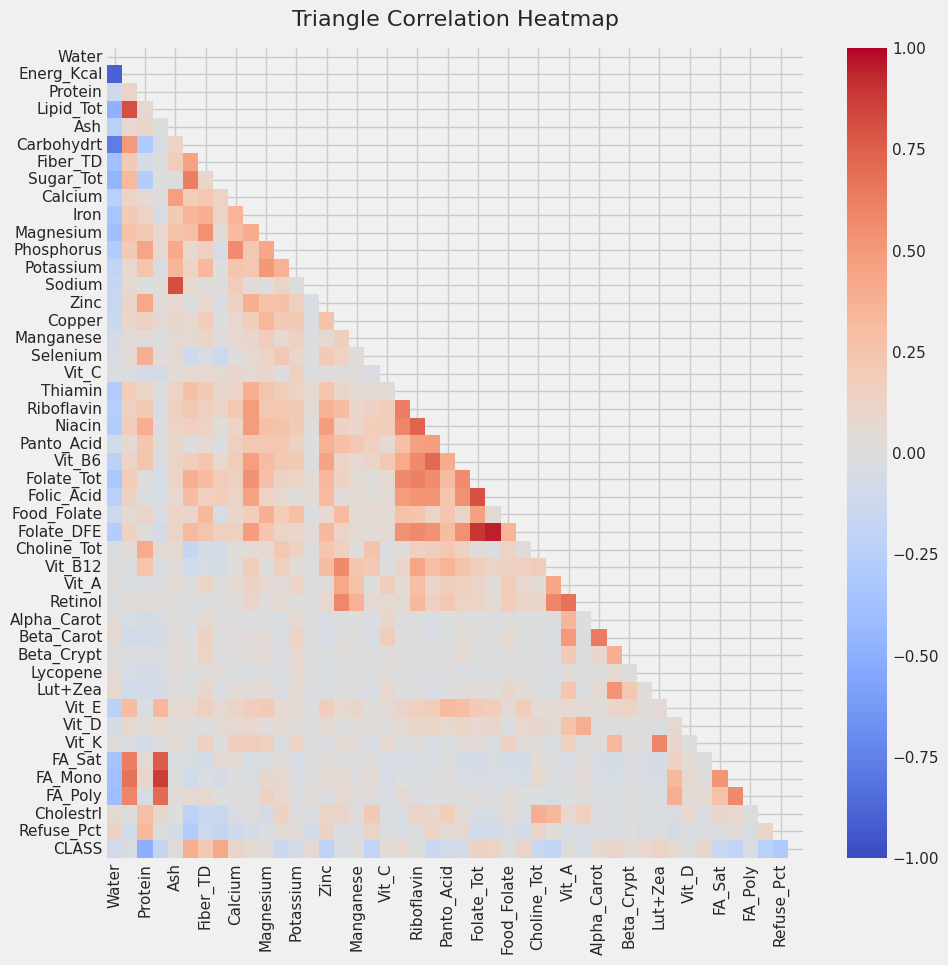

In [ ]:
heatmap = plt.figure(figsize=(10, 10))

mask = np.triu(np.ones(data.corr().shape), k=0).astype(bool)
heatmap = sns.heatmap(data.corr(), mask=mask, vmin=-1, vmax=1, annot=False, cmap='coolwarm') 
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':16}, pad=16);

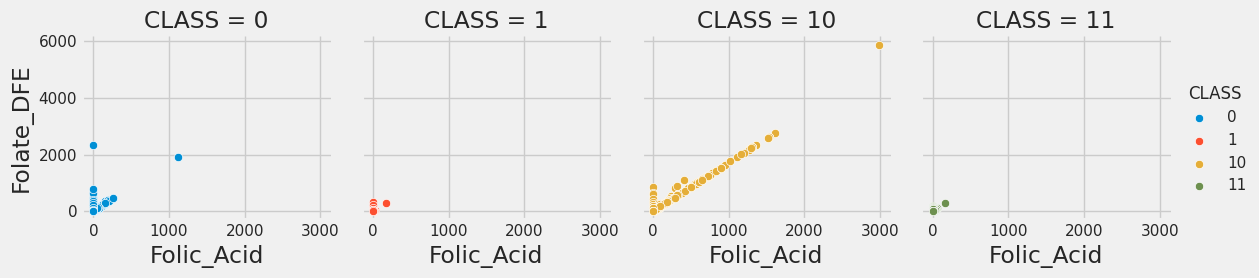

In [ ]:
grid = sns.FacetGrid(data, col="CLASS", hue="CLASS", col_wrap=4)
grid.map(sns.scatterplot, "Folic_Acid", "Folate_DFE")
grid.add_legend();

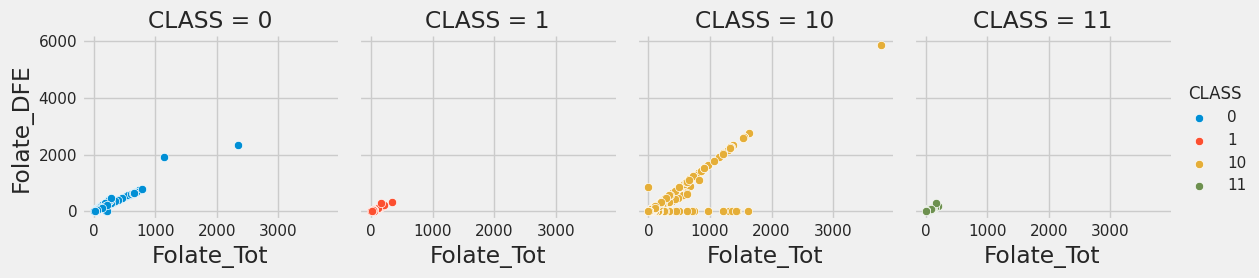

In [ ]:
grid = sns.FacetGrid(data, col="CLASS", hue="CLASS", col_wrap=4)
grid.map(sns.scatterplot, "Folate_Tot", "Folate_DFE")
grid.add_legend();

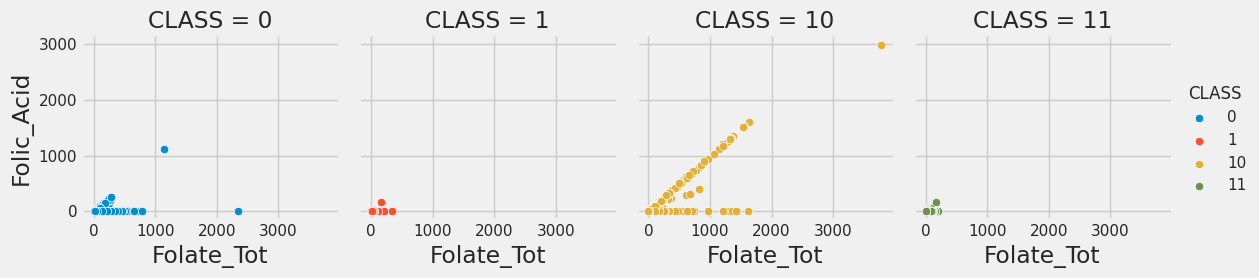

In [ ]:
grid = sns.FacetGrid(data, col="CLASS", hue="CLASS", col_wrap=4)
grid.map(sns.scatterplot, "Folate_Tot", "Folic_Acid")
grid.add_legend();

In [ ]:
data[(data['CLASS'] == 10) & (data['Folate_Tot'] > 3000)]

,Shrt_Desc,Water,Energ_Kcal,Protein,Lipid_Tot,Ash,Carbohydrt,Fiber_TD,Sugar_Tot,Calcium,Iron,Magnesium,Phosphorus,Potassium,Sodium,Zinc,Copper,Manganese,Selenium,Vit_C,Thiamin,Riboflavin,Niacin,Panto_Acid,Vit_B6,Folate_Tot,Folic_Acid,Food_Folate,Folate_DFE,Choline_Tot,Vit_B12,Vit_A,Retinol,Alpha_Carot,Beta_Carot,Beta_Crypt,Lycopene,Lut+Zea,Vit_E,Vit_D,Vit_K,FA_Sat,FA_Mono,FA_Poly,Cholestrl,Refuse_Pct,CLASS
8734,YEAST EXTRACT SPREAD,40900000.0,185,23880000.0,900000.0,13900000.0,20420000.0,6500000.0,1600000.0,67000.0,4040.0,180000.0,104000.0,2100000.0,3380000.0,4190.0,245.0,261.0,27.6,0.0,23375.0,17500.0,127500.0,4600.0,0.0,3786.0,2993.0,793.0,5881.0,65100.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10


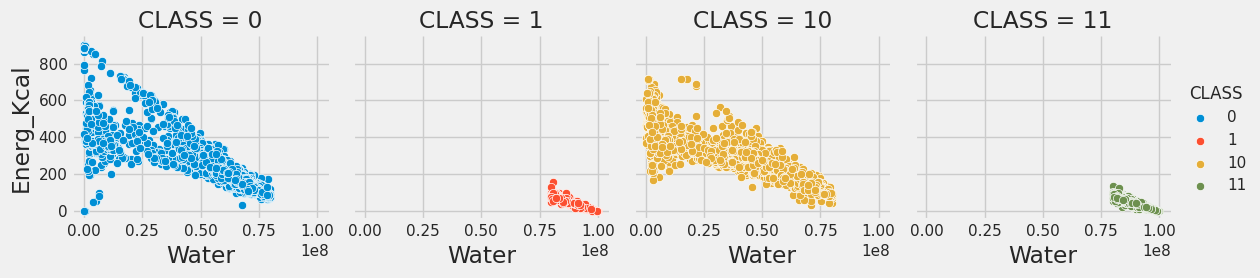

In [ ]:
grid = sns.FacetGrid(data, col="CLASS", hue="CLASS", col_wrap=4)
grid.map(sns.scatterplot, "Water", "Energ_Kcal")
grid.add_legend();

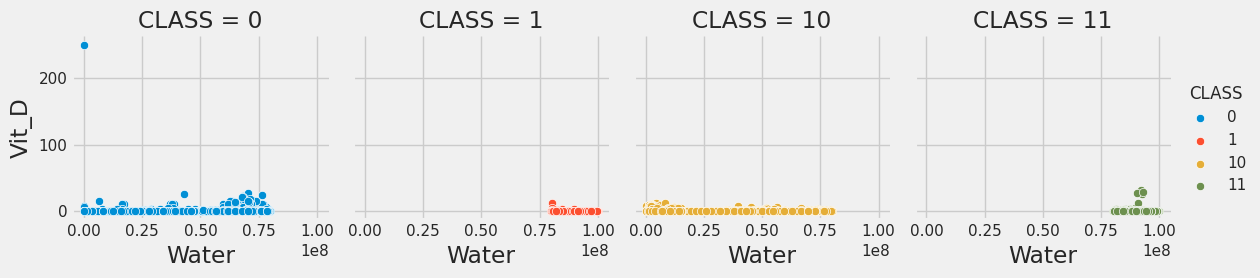

In [ ]:
grid = sns.FacetGrid(data, col="CLASS", hue="CLASS", col_wrap=4)
grid.map(sns.scatterplot, "Water", "Vit_D")
grid.add_legend();

In [ ]:
data[(data['CLASS'] == 0) & (data['Vit_D'] == 250)]

,Shrt_Desc,Water,Energ_Kcal,Protein,Lipid_Tot,Ash,Carbohydrt,Fiber_TD,Sugar_Tot,Calcium,Iron,Magnesium,Phosphorus,Potassium,Sodium,Zinc,Copper,Manganese,Selenium,Vit_C,Thiamin,Riboflavin,Niacin,Panto_Acid,Vit_B6,Folate_Tot,Folic_Acid,Food_Folate,Folate_DFE,Choline_Tot,Vit_B12,Vit_A,Retinol,Alpha_Carot,Beta_Carot,Beta_Crypt,Lycopene,Lut+Zea,Vit_E,Vit_D,Vit_K,FA_Sat,FA_Mono,FA_Poly,Cholestrl,Refuse_Pct,CLASS
724,"FISH OIL,COD LIVER",0.0,902,0.0,100000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30000.0,30000.0,0.0,0.0,0.0,0.0,0.0,0.0,250.0,0.0,22608000.0,46711000.0,22541000.0,570000.0,0.0,0


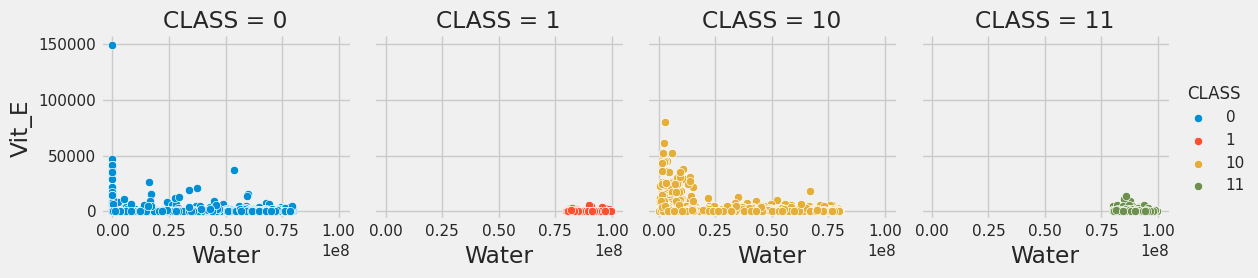

In [ ]:
grid = sns.FacetGrid(data, col="CLASS", hue="CLASS", col_wrap=4)
grid.map(sns.scatterplot, "Water", "Vit_E")
grid.add_legend();

In [ ]:
data[(data['CLASS'] == 0) & (data['Vit_E'] > 140000)]

,Shrt_Desc,Water,Energ_Kcal,Protein,Lipid_Tot,Ash,Carbohydrt,Fiber_TD,Sugar_Tot,Calcium,Iron,Magnesium,Phosphorus,Potassium,Sodium,Zinc,Copper,Manganese,Selenium,Vit_C,Thiamin,Riboflavin,Niacin,Panto_Acid,Vit_B6,Folate_Tot,Folic_Acid,Food_Folate,Folate_DFE,Choline_Tot,Vit_B12,Vit_A,Retinol,Alpha_Carot,Beta_Carot,Beta_Crypt,Lycopene,Lut+Zea,Vit_E,Vit_D,Vit_K,FA_Sat,FA_Mono,FA_Poly,Cholestrl,Refuse_Pct,CLASS
655,"OIL,WHEAT GERM",0.0,884,0.0,100000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,149400.0,0.0,24.7,18800000.0,15100000.0,61700000.0,0.0,0.0,0


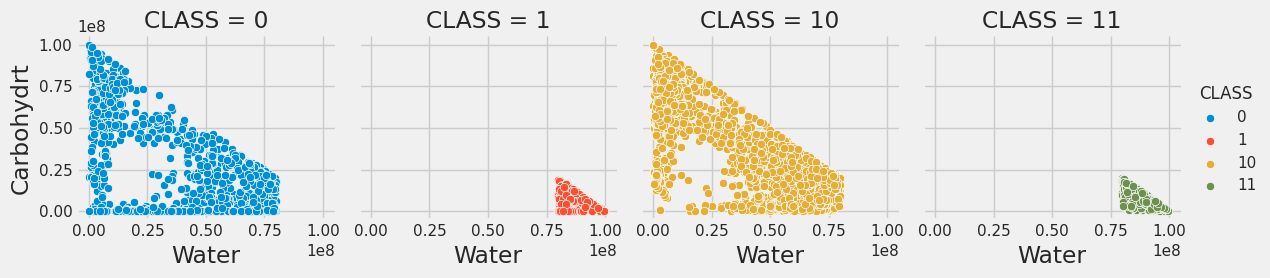

In [ ]:
grid = sns.FacetGrid(data, col="CLASS", hue="CLASS", col_wrap=4)
grid.map(sns.scatterplot, "Water", "Carbohydrt")
grid.add_legend();

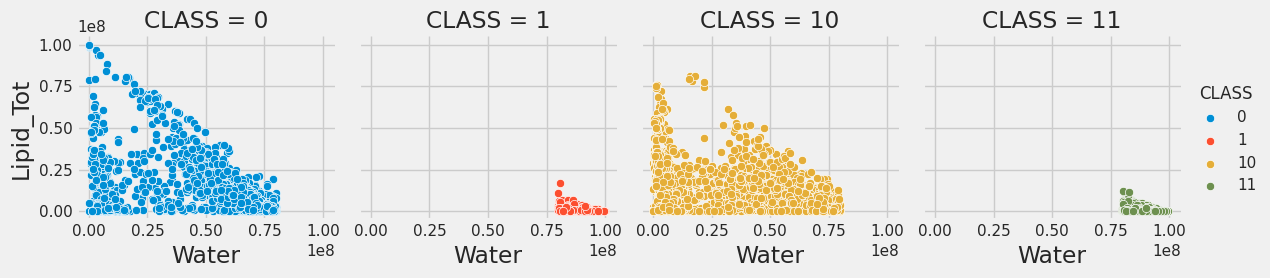

In [ ]:
grid = sns.FacetGrid(data, col="CLASS", hue="CLASS", col_wrap=4)
grid.map(sns.scatterplot, "Water", "Lipid_Tot")
grid.add_legend();

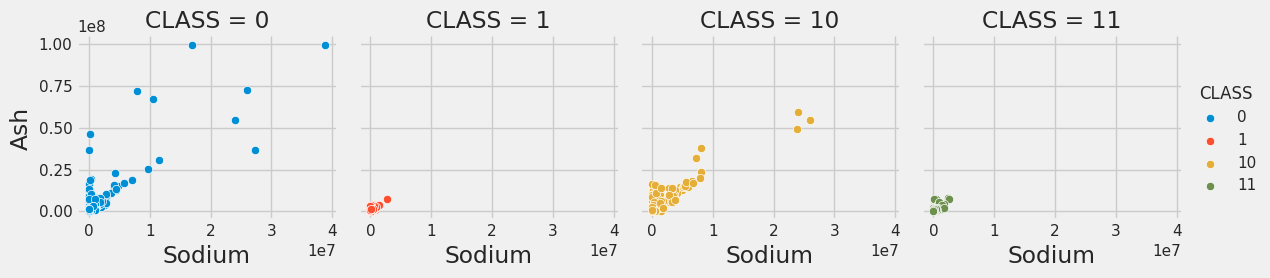

In [ ]:
grid = sns.FacetGrid(data, col="CLASS", hue="CLASS", col_wrap=4)
grid.map(sns.scatterplot, "Sodium", "Ash")
grid.add_legend();

## **Подготовка набора данных для использования метода k ближайших соседей**

### Пропуски были ранее заполнены нулевыми значениями

### Дубликатов нет

In [ ]:
print(f'Количество дубликатов в данных = {len(data[data.duplicated()])}')

Количество дубликатов в данных = 0


### Работа с категориальными признаками

In [ ]:
data1 = data.copy()

In [ ]:
data1.Shrt_Desc = data1.Shrt_Desc.str.split(',').str[0]
data1

,Shrt_Desc,Water,Energ_Kcal,Protein,Lipid_Tot,Ash,Carbohydrt,Fiber_TD,Sugar_Tot,Calcium,Iron,Magnesium,Phosphorus,Potassium,Sodium,Zinc,Copper,Manganese,Selenium,Vit_C,Thiamin,Riboflavin,Niacin,Panto_Acid,Vit_B6,Folate_Tot,Folic_Acid,Food_Folate,Folate_DFE,Choline_Tot,Vit_B12,Vit_A,Retinol,Alpha_Carot,Beta_Carot,Beta_Crypt,Lycopene,Lut+Zea,Vit_E,Vit_D,Vit_K,FA_Sat,FA_Mono,FA_Poly,Cholestrl,Refuse_Pct,CLASS
0,BUTTER,15870000.0,717,850000.0,81110000.0,2110000.0,60000.0,0.0,60000.0,24000.0,20.0,2000.0,24000.0,24000.0,643000.0,90.0,0.0,0.0,1.0,0.0,5.0,34.0,42.0,110.0,3.0,3.0,0.0,3.0,3.0,18800.0,0.17,749.7,671.0,0.0,158.0,0.0,0.0,0.0,2320.0,0.000,7.0,51368000.0,21021000.0,3043000.0,215000.0,0.0,10
1,BUTTER,16720000.0,718,490000.0,78300000.0,1620000.0,2870000.0,0.0,60000.0,23000.0,50.0,1000.0,24000.0,41000.0,583000.0,50.0,10.0,1.0,0.0,0.0,7.0,64.0,22.0,97.0,8.0,4.0,0.0,4.0,4.0,18800.0,0.07,740.4,671.0,1.0,135.0,6.0,0.0,13.0,1370.0,0.000,4.6,45390000.0,19874000.0,3331000.0,225000.0,0.0,10
2,BUTTER OIL,240000.0,876,280000.0,99480000.0,0.0,0.0,0.0,0.0,4000.0,0.0,0.0,3000.0,5000.0,2000.0,10.0,1.0,0.0,0.0,0.0,1.0,5.0,3.0,10.0,1.0,0.0,0.0,0.0,0.0,22300.0,0.01,920.7,824.0,0.0,193.0,0.0,0.0,0.0,2800.0,0.000,8.6,61924000.0,28732000.0,3694000.0,256000.0,0.0,0
3,CHEESE,42410000.0,353,21400000.0,28740000.0,5110000.0,2340000.0,0.0,500000.0,528000.0,310.0,23000.0,387000.0,256000.0,1146000.0,2660.0,40.0,9.0,14.5,0.0,29.0,382.0,1016.0,1729.0,166.0,36.0,0.0,36.0,36.0,15400.0,1.22,216.3,192.0,0.0,74.0,0.0,0.0,0.0,250.0,0.525,2.4,18669000.0,7778000.0,800000.0,75000.0,0.0,10
4,CHEESE,41110000.0,371,23240000.0,29680000.0,3180000.0,2790000.0,0.0,510000.0,674000.0,430.0,24000.0,451000.0,136000.0,560000.0,2600.0,24.0,12.0,14.5,0.0,14.0,351.0,118.0,288.0,65.0,20.0,0.0,20.0,20.0,15400.0,1.26,324.0,286.0,0.0,76.0,0.0,0.0,0.0,260.0,0.550,2.5,18764000.0,8598000.0,784000.0,94000.0,0.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8785,MACKEREL,43000000.0,305,18500000.0,25100000.0,13400000.0,0.0,0.0,0.0,66000.0,1400.0,60000.0,254000.0,520000.0,4450000.0,1100.0,100.0,0.0,73.4,0.0,20.0,190.0,3300.0,0.0,410.0,15.0,0.0,15.0,15.0,101600.0,12.00,47.1,47.0,0.0,0.0,0.0,0.0,0.0,2380.0,25.150,7.8,7148000.0,8320000.0,6210000.0,95000.0,0.0,0
8786,SCALLOP,70250000.0,111,20540000.0,840000.0,2970000.0,5410000.0,0.0,0.0,10000.0,580.0,37000.0,426000.0,314000.0,667000.0,1550.0,33.0,29.0,21.7,0.0,12.0,24.0,1076.0,366.0,112.0,20.0,0.0,20.0,20.0,110700.0,2.15,1.5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050,0.0,218000.0,82000.0,222000.0,41000.0,0.0,0
8787,SYRUP,26000000.0,269,0.0,0.0,860000.0,73140000.0,0.0,73200000.0,13000.0,3600.0,10000.0,8000.0,63000.0,58000.0,190.0,20.0,0.0,0.7,0.0,130.0,60.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,10
8788,SNAIL,79200000.0,90,16100000.0,1400000.0,1300000.0,2000000.0,0.0,0.0,10000.0,3500.0,250000.0,272000.0,382000.0,70000.0,1000.0,400.0,0.0,27.4,0.0,10.0,120.0,1400.0,0.0,130.0,6.0,0.0,6.0,6.0,65000.0,0.50,30.0,30.0,0.0,0.0,0.0,0.0,0.0,5000.0,0.000,0.1,361000.0,259000.0,252000.0,50000.0,0.0,0


In [ ]:
data1['Shrt_Desc'].value_counts()

BEEF                                    929
PORK                                    322
LAMB                                    295
CEREALS RTE                             258
BEVERAGES                               247
                                       ... 
VEGGIE BURGERS OR SOYBURGERS  UNPREP      1
PEANUT SPRD                               1
CHICKPEA FLOUR (BESAN)                    1
VEG-OIL SPRD                              1
TURTLE                                    1
Name: Shrt_Desc, Length: 1392, dtype: int64

In [ ]:
data1.Shrt_Desc = data1.Shrt_Desc.str.split(' ').str[0]

len(list(data1['Shrt_Desc'].unique()))

852

In [ ]:
sorted(list(data1['Shrt_Desc'].unique()))

['ABALONE',
 'ABIYUCH',
 'ACEROLA',
 'ACORN',
 'ACORNS',
 'AGAVE',
 'AGUTUK',
 'ALCOHOLIC',
 'ALFALFA',
 'ALLSPICE',
 'ALMOND',
 'ALMONDS',
 'AMARANTH',
 'ANCHOVY',
 "ANDREA'S",
 'ANIMAL',
 'ANISE',
 'APPLE',
 "APPLEBEE'S",
 'APPLES',
 'APPLESAUCE',
 'APRICOT',
 'APRICOTS',
 "ARBY'S",
 'ARCHWAY',
 'ARROWHEAD',
 'ARROWROOT',
 'ARTICHOKES',
 'ARTIFICIAL',
 'ARUGULA',
 'ASCIDIANS',
 'ASPARAGUS',
 'AUSTIN',
 'AVOCADOS',
 'BABYFD',
 'BABYFOO',
 'BABYFOOD',
 'BACON',
 'BAGEL',
 'BAGELS',
 'BAK',
 'BAKING',
 'BALSAM-PEAR',
 'BAMBOO',
 'BANANA',
 'BANANAS',
 'BANQUET',
 'BARBARA',
 'BARBECUE',
 'BARLEY',
 'BASIL',
 'BASS',
 'BEANS',
 'BEAR',
 'BEECHNUTS',
 'BEEF',
 'BEERWURST',
 'BEET',
 'BEETS',
 'BEV',
 'BEVE',
 'BEVER',
 'BEVERA',
 'BEVERAG',
 'BEVERAGE',
 'BEVERAGES',
 'BF',
 'BISCUIT',
 'BISCUITS',
 'BISON',
 'BLACKBERRIES',
 'BLACKBERRY',
 'BLOOD',
 'BLUEBERRIES',
 'BLUEFISH',
 'BOCKWURST',
 'BOLOGNA',
 'BORAGE',
 'BOYSENBERRIES',
 'BRATWURST',
 'BRAUNSCHWEIGER',
 'BRAZILNUTS',
 'BRD',
 

In [ ]:
data1 = pd.get_dummies(data1, columns=['Shrt_Desc'])
data1

,Water,Energ_Kcal,Protein,Lipid_Tot,Ash,Carbohydrt,Fiber_TD,Sugar_Tot,Calcium,Iron,Magnesium,Phosphorus,Potassium,Sodium,Zinc,Copper,Manganese,Selenium,Vit_C,Thiamin,Riboflavin,Niacin,Panto_Acid,Vit_B6,Folate_Tot,Folic_Acid,Food_Folate,Folate_DFE,Choline_Tot,Vit_B12,Vit_A,Retinol,Alpha_Carot,Beta_Carot,Beta_Crypt,Lycopene,Lut+Zea,Vit_E,Vit_D,Vit_K,FA_Sat,FA_Mono,FA_Poly,Cholestrl,Refuse_Pct,CLASS,Shrt_Desc_ABALONE,Shrt_Desc_ABIYUCH,Shrt_Desc_ACEROLA,Shrt_Desc_ACORN,Shrt_Desc_ACORNS,Shrt_Desc_AGAVE,Shrt_Desc_AGUTUK,Shrt_Desc_ALCOHOLIC,Shrt_Desc_ALFALFA,Shrt_Desc_ALLSPICE,Shrt_Desc_ALMOND,Shrt_Desc_ALMONDS,Shrt_Desc_AMARANTH,Shrt_Desc_ANCHOVY,Shrt_Desc_ANDREA'S,Shrt_Desc_ANIMAL,Shrt_Desc_ANISE,Shrt_Desc_APPLE,Shrt_Desc_APPLEBEE'S,Shrt_Desc_APPLES,Shrt_Desc_APPLESAUCE,Shrt_Desc_APRICOT,Shrt_Desc_APRICOTS,Shrt_Desc_ARBY'S,Shrt_Desc_ARCHWAY,Shrt_Desc_ARROWHEAD,Shrt_Desc_ARROWROOT,Shrt_Desc_ARTICHOKES,Shrt_Desc_ARTIFICIAL,Shrt_Desc_ARUGULA,Shrt_Desc_ASCIDIANS,Shrt_Desc_ASPARAGUS,Shrt_Desc_AUSTIN,Shrt_Desc_AVOCADOS,Shrt_Desc_BABYFD,Shrt_Desc_BABYFOO,Shrt_Desc_BABYFOOD,Shrt_Desc_BACON,Shrt_Desc_BAGEL,Shrt_Desc_BAGELS,Shrt_Desc_BAK,Shrt_Desc_BAKING,Shrt_Desc_BALSAM-PEAR,Shrt_Desc_BAMBOO,Shrt_Desc_BANANA,Shrt_Desc_BANANAS,Shrt_Desc_BANQUET,Shrt_Desc_BARBARA,Shrt_Desc_BARBECUE,Shrt_Desc_BARLEY,Shrt_Desc_BASIL,Shrt_Desc_BASS,Shrt_Desc_BEANS,Shrt_Desc_BEAR,Shrt_Desc_BEECHNUTS,Shrt_Desc_BEEF,Shrt_Desc_BEERWURST,Shrt_Desc_BEET,Shrt_Desc_BEETS,Shrt_Desc_BEV,Shrt_Desc_BEVE,Shrt_Desc_BEVER,Shrt_Desc_BEVERA,Shrt_Desc_BEVERAG,Shrt_Desc_BEVERAGE,Shrt_Desc_BEVERAGES,Shrt_Desc_BF,Shrt_Desc_BISCUIT,Shrt_Desc_BISCUITS,Shrt_Desc_BISON,Shrt_Desc_BLACKBERRIES,Shrt_Desc_BLACKBERRY,Shrt_Desc_BLOOD,Shrt_Desc_BLUEBERRIES,Shrt_Desc_BLUEFISH,Shrt_Desc_BOCKWURST,Shrt_Desc_BOLOGNA,Shrt_Desc_BORAGE,Shrt_Desc_BOYSENBERRIES,Shrt_Desc_BRATWURST,Shrt_Desc_BRAUNSCHWEIGER,Shrt_Desc_BRAZILNUTS,Shrt_Desc_BRD,Shrt_Desc_BREAD,Shrt_Desc_BREADFRUIT,Shrt_Desc_BREAKFAST,Shrt_Desc_BROADBEANS,Shrt_Desc_BROCCOLI,Shrt_Desc_BROTWURST,Shrt_Desc_BRUSSELS,Shrt_Desc_BUCKWHEAT,Shrt_Desc_BUFFALO,Shrt_Desc_BULGUR,Shrt_Desc_BURBOT,Shrt_Desc_BURDOCK,Shrt_Desc_BURGER,Shrt_Desc_BURRITO,Shrt_Desc_BUTTER,Shrt_Desc_BUTTERBUR,Shrt_Desc_BUTTERFISH,Shrt_Desc_BUTTERNUTS,Shrt_Desc_Babyfood,Shrt_Desc_Baking,Shrt_Desc_Beef,Shrt_Desc_Beverages,Shrt_Desc_Bread,Shrt_Desc_CABBAGE,Shrt_Desc_CAKE,Shrt_Desc_CAMPBELL'S,Shrt_Desc_CAMPBELLS,Shrt_Desc_CANADA,Shrt_Desc_CANADIAN,Shrt_Desc_CANDIED,Shrt_Desc_CANDIES,Shrt_Desc_CAPERS,Shrt_Desc_CARAMBOLA,Shrt_Desc_CARAWAY,Shrt_Desc_CARBONATED,Shrt_Desc_CARDOON,Shrt_Desc_CARIBOU,Shrt_Desc_CARISSA,Shrt_Desc_CAROB,Shrt_Desc_CARP,Shrt_Desc_CARRABBA'S,Shrt_Desc_CARROT,Shrt_Desc_CARROTS,Shrt_Desc_CASHEW,Shrt_Desc_CASSAVA,Shrt_Desc_CATFISH,Shrt_Desc_CATSUP,Shrt_Desc_CATTAIL,Shrt_Desc_CAULIFLOWER,Shrt_Desc_CAVIAR,Shrt_Desc_CELERIAC,Shrt_Desc_CELERY,Shrt_Desc_CELTUCE,Shrt_Desc_CEREALS,Shrt_Desc_CHARD,Shrt_Desc_CHAYOTE,Shrt_Desc_CHCKN,Shrt_Desc_CHEESE,Shrt_Desc_CHEESECAKE,Shrt_Desc_CHEESEFURTER,Shrt_Desc_CHERIMOYA,Shrt_Desc_CHERRIES,Shrt_Desc_CHERVIL,Shrt_Desc_CHESTNUTS,Shrt_Desc_CHEWING,Shrt_Desc_CHI,Shrt_Desc_CHIA,Shrt_Desc_CHICK,Shrt_Desc_CHICK-FIL-A,Shrt_Desc_CHICKEN,Shrt_Desc_CHICKPEA,Shrt_Desc_CHICKPEAS,Shrt_Desc_CHICORY,Shrt_Desc_CHICkN,Shrt_Desc_CHILCHEN,Shrt_Desc_CHILD,Shrt_Desc_CHILI,Shrt_Desc_CHITON,Shrt_Desc_CHIVES,Shrt_Desc_CHOCOLATE,Shrt_Desc_CHOCOLATE-FLAVORED,Shrt_Desc_CHOKECHERRIES,Shrt_Desc_CHORIZO,Shrt_Desc_CHRYSANTHEMUM,Shrt_Desc_CINNAMON,Shrt_Desc_CISCO,Shrt_Desc_CKN,Shrt_Desc_CLAM,Shrt_Desc_CLEMENTINES,Shrt_Desc_CLIF,Shrt_Desc_CLOUDBERRIES,Shrt_Desc_CLOVES,Shrt_Desc_COCKLES,Shrt_Desc_COCOA,Shrt_Desc_COCONUT,Shrt_Desc_COD,Shrt_Desc_COFFEECAKE,Shrt_Desc_COLLARDS,Shrt_Desc_CONCH,Shrt_Desc_COOKIE,Shrt_Desc_COOKIES,Shrt_Desc_CORIANDER,Shrt_Desc_CORN,Shrt_Desc_CORN-BASED,Shrt_Desc_CORNED,Shrt_Desc_CORNMEAL,Shrt_Desc_CORNNUTS,Shrt_Desc_CORNSALAD,Shrt_Desc_CORNSTARCH,Shrt_Desc_COTTONSEED,Shrt_Desc_COUSCOUS,Shrt_Desc_COWPEAS,Shrt_Desc_CRAB,Shrt_Desc_CRABAPPLES,Shrt_

### Разбивка данных на тренировочный и тестовый наборы

In [ ]:
data

,Shrt_Desc,Water,Energ_Kcal,Protein,Lipid_Tot,Ash,Carbohydrt,Fiber_TD,Sugar_Tot,Calcium,Iron,Magnesium,Phosphorus,Potassium,Sodium,Zinc,Copper,Manganese,Selenium,Vit_C,Thiamin,Riboflavin,Niacin,Panto_Acid,Vit_B6,Folate_Tot,Folic_Acid,Food_Folate,Folate_DFE,Choline_Tot,Vit_B12,Vit_A,Retinol,Alpha_Carot,Beta_Carot,Beta_Crypt,Lycopene,Lut+Zea,Vit_E,Vit_D,Vit_K,FA_Sat,FA_Mono,FA_Poly,Cholestrl,Refuse_Pct,CLASS
0,"BUTTER,WITH SALT",15870000.0,717,850000.0,81110000.0,2110000.0,60000.0,0.0,60000.0,24000.0,20.0,2000.0,24000.0,24000.0,643000.0,90.0,0.0,0.0,1.0,0.0,5.0,34.0,42.0,110.0,3.0,3.0,0.0,3.0,3.0,18800.0,0.17,749.7,671.0,0.0,158.0,0.0,0.0,0.0,2320.0,0.000,7.0,51368000.0,21021000.0,3043000.0,215000.0,0.0,10
1,"BUTTER,WHIPPED,W/ SALT",16720000.0,718,490000.0,78300000.0,1620000.0,2870000.0,0.0,60000.0,23000.0,50.0,1000.0,24000.0,41000.0,583000.0,50.0,10.0,1.0,0.0,0.0,7.0,64.0,22.0,97.0,8.0,4.0,0.0,4.0,4.0,18800.0,0.07,740.4,671.0,1.0,135.0,6.0,0.0,13.0,1370.0,0.000,4.6,45390000.0,19874000.0,3331000.0,225000.0,0.0,10
2,"BUTTER OIL,ANHYDROUS",240000.0,876,280000.0,99480000.0,0.0,0.0,0.0,0.0,4000.0,0.0,0.0,3000.0,5000.0,2000.0,10.0,1.0,0.0,0.0,0.0,1.0,5.0,3.0,10.0,1.0,0.0,0.0,0.0,0.0,22300.0,0.01,920.7,824.0,0.0,193.0,0.0,0.0,0.0,2800.0,0.000,8.6,61924000.0,28732000.0,3694000.0,256000.0,0.0,0
3,"CHEESE,BLUE",42410000.0,353,21400000.0,28740000.0,5110000.0,2340000.0,0.0,500000.0,528000.0,310.0,23000.0,387000.0,256000.0,1146000.0,2660.0,40.0,9.0,14.5,0.0,29.0,382.0,1016.0,1729.0,166.0,36.0,0.0,36.0,36.0,15400.0,1.22,216.3,192.0,0.0,74.0,0.0,0.0,0.0,250.0,0.525,2.4,18669000.0,7778000.0,800000.0,75000.0,0.0,10
4,"CHEESE,BRICK",41110000.0,371,23240000.0,29680000.0,3180000.0,2790000.0,0.0,510000.0,674000.0,430.0,24000.0,451000.0,136000.0,560000.0,2600.0,24.0,12.0,14.5,0.0,14.0,351.0,118.0,288.0,65.0,20.0,0.0,20.0,20.0,15400.0,1.26,324.0,286.0,0.0,76.0,0.0,0.0,0.0,260.0,0.550,2.5,18764000.0,8598000.0,784000.0,94000.0,0.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8785,"MACKEREL,SALTED",43000000.0,305,18500000.0,25100000.0,13400000.0,0.0,0.0,0.0,66000.0,1400.0,60000.0,254000.0,520000.0,4450000.0,1100.0,100.0,0.0,73.4,0.0,20.0,190.0,3300.0,0.0,410.0,15.0,0.0,15.0,15.0,101600.0,12.00,47.1,47.0,0.0,0.0,0.0,0.0,0.0,2380.0,25.150,7.8,7148000.0,8320000.0,6210000.0,95000.0,0.0,0
8786,"SCALLOP,(BAY&SEA),CKD,STMD",70250000.0,111,20540000.0,840000.0,2970000.0,5410000.0,0.0,0.0,10000.0,580.0,37000.0,426000.0,314000.0,667000.0,1550.0,33.0,29.0,21.7,0.0,12.0,24.0,1076.0,366.0,112.0,20.0,0.0,20.0,20.0,110700.0,2.15,1.5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050,0.0,218000.0,82000.0,222000.0,41000.0,0.0,0
8787,"SYRUP,CANE",26000000.0,269,0.0,0.0,860000.0,73140000.0,0.0,73200000.0,13000.0,3600.0,10000.0,8000.0,63000.0,58000.0,190.0,20.0,0.0,0.7,0.0,130.0,60.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,10
8788,"SNAIL,RAW",79200000.0,90,16100000.0,1400000.0,1300000.0,2000000.0,0.0,0.0,10000.0,3500.0,250000.0,272000.0,382000.0,70000.0,1000.0,400.0,0.0,27.4,0.0,10.0,120.0,1400.0,0.0,130.0,6.0,0.0,6.0,6.0,65000.0,0.50,30.0,30.0,0.0,0.0,0.0,0.0,0.0,5000.0,0.000,0.1,361000.0,259000.0,252000.0,50000.0,0.0,0


In [ ]:
y = data['CLASS'].values
data.drop(columns='Shrt_Desc', inplace=True)

X = data.loc[:, data.columns !='CLASS'].values

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=53)

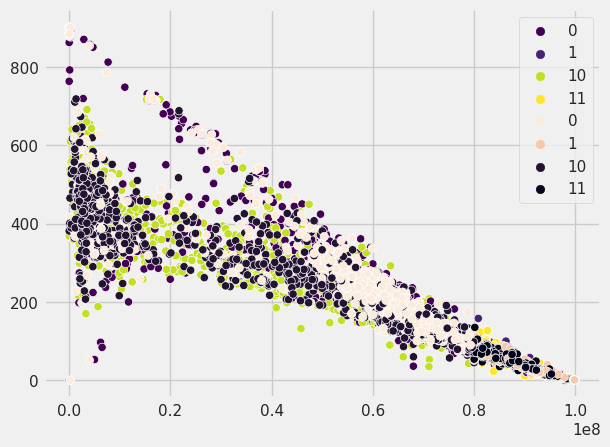

In [ ]:
sns.scatterplot(x=X_train[:, 0].ravel(), y=X_train[:, 1], hue=y_train, palette='viridis')
sns.scatterplot(x=X_test[:, 0].ravel(), y=X_test[:, 1], hue=y_test, palette='rocket_r');

## **Обучение классификатора KNeighborsClassifier на тренировочном наборе**

In [ ]:
dict_score = {}

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)

KNeighborsClassifier()

## **Оценка полученных результатов. Визуализация и различные метрики**

In [ ]:
score = clf.score(X_test, y_test)
score

0.8953356086461889

In [ ]:
dict_score['первый вариант (без подбора параметров)']= score

1 0.9059537353052711
2 0.8960940462646947
3 0.90064467197573
4 0.8976109215017065
5 0.8953356086461889
6 0.8968524838832006
7 0.8904057641259007
8 0.8926810769814183
9 0.8869927948426242
10 0.8869927948426242


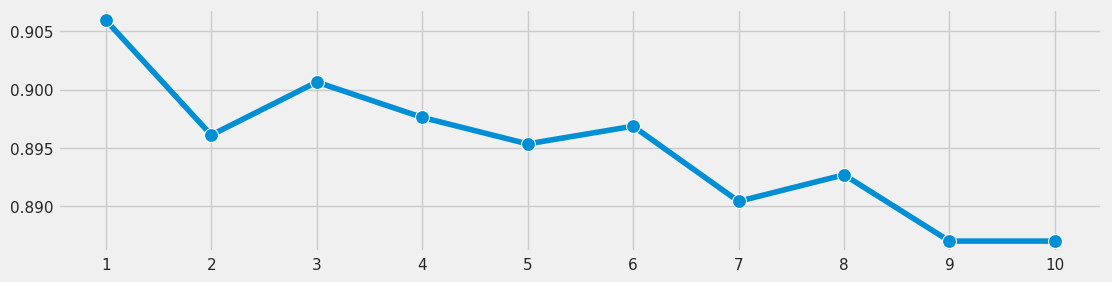

In [ ]:
scores = []
for k in range(1, 11):
    clf = KNeighborsClassifier(k)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    dict_score[f'1) k={k}'] = score
    print(k, score)
    scores.append(score)
plt.figure(figsize=(12, 3))
sns.lineplot(x=map(str, range(1, 11)), y=scores, marker='o', markersize=10);

In [ ]:
clf = KNeighborsClassifier(metric='manhattan')
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
score

0.9082290481607888

In [ ]:
dict_score['1) с метрикой manhattan'] = score

1 0.9086082669700417
2 0.8957148274554418
3 0.907470610542283
4 0.9036784224497535
5 0.9082290481607888
6 0.9051952976867652
7 0.9051952976867652
8 0.9044368600682594
9 0.9032992036405005
10 0.9089874857792947


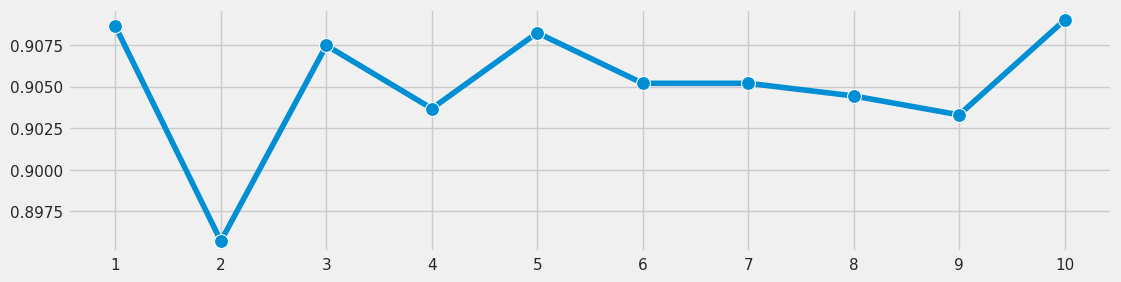

In [ ]:
scores = []
for k in range(1, 11):
    clf = KNeighborsClassifier(k, metric='manhattan')
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(k, score)
    dict_score[f'1) k={k} с метрикой manhattan'] = score
    scores.append(score)
plt.figure(figsize=(12, 3))
sns.lineplot(x=map(str, range(1, 11)), y=scores, marker='o', markersize=10);

**1ый вариант**

In [ ]:
!pip install scikit-learn --upgrade --no-deps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


{(15, 21), (7, 17), (15, 30), (26, 30), (7, 26), (18, 26), (15, 39), (26, 39), (7, 35), (18, 35), (29, 32), (18, 44), (8, 9), (0, 5), (29, 41), (8, 18), (21, 37), (40, 41), (0, 14), (11, 14), (21, 46), (0, 23), (11, 23), (10, 27), (41, 42), (10, 36), (33, 38), (2, 32), (25, 34), (10, 45), (2, 41), (3, 6), (25, 43), (3, 15), (14, 15), (22, 28), (3, 24), (14, 24), (22, 37), (3, 33), (14, 33), (22, 46), (3, 42), (14, 42), (15, 16), (7, 12), (15, 25), (17, 44), (7, 21), (18, 21), (7, 30), (18, 30), (6, 34), (29, 36), (21, 32), (0, 9), (6, 43), (29, 45), (21, 41), (40, 45), (10, 22), (10, 31), (2, 27), (25, 29), (10, 40), (33, 42), (2, 36), (25, 38), (2, 45), (3, 10), (22, 23), (3, 19), (14, 19), (22, 32), (3, 28), (14, 28), (3, 37), (14, 37), (36, 43), (17, 39), (28, 39), (7, 16), (5, 46), (9, 44), (6, 29), (29, 31), (21, 27), (6, 38), (29, 40), (21, 36), (21, 45), (10, 17), (2, 13), (10, 26), (2, 22), (10, 35), (33, 37), (2, 31), (25, 33), (10, 44), (2, 40), (3, 5), (25, 42), (32, 41), (3

ValueError: ignored

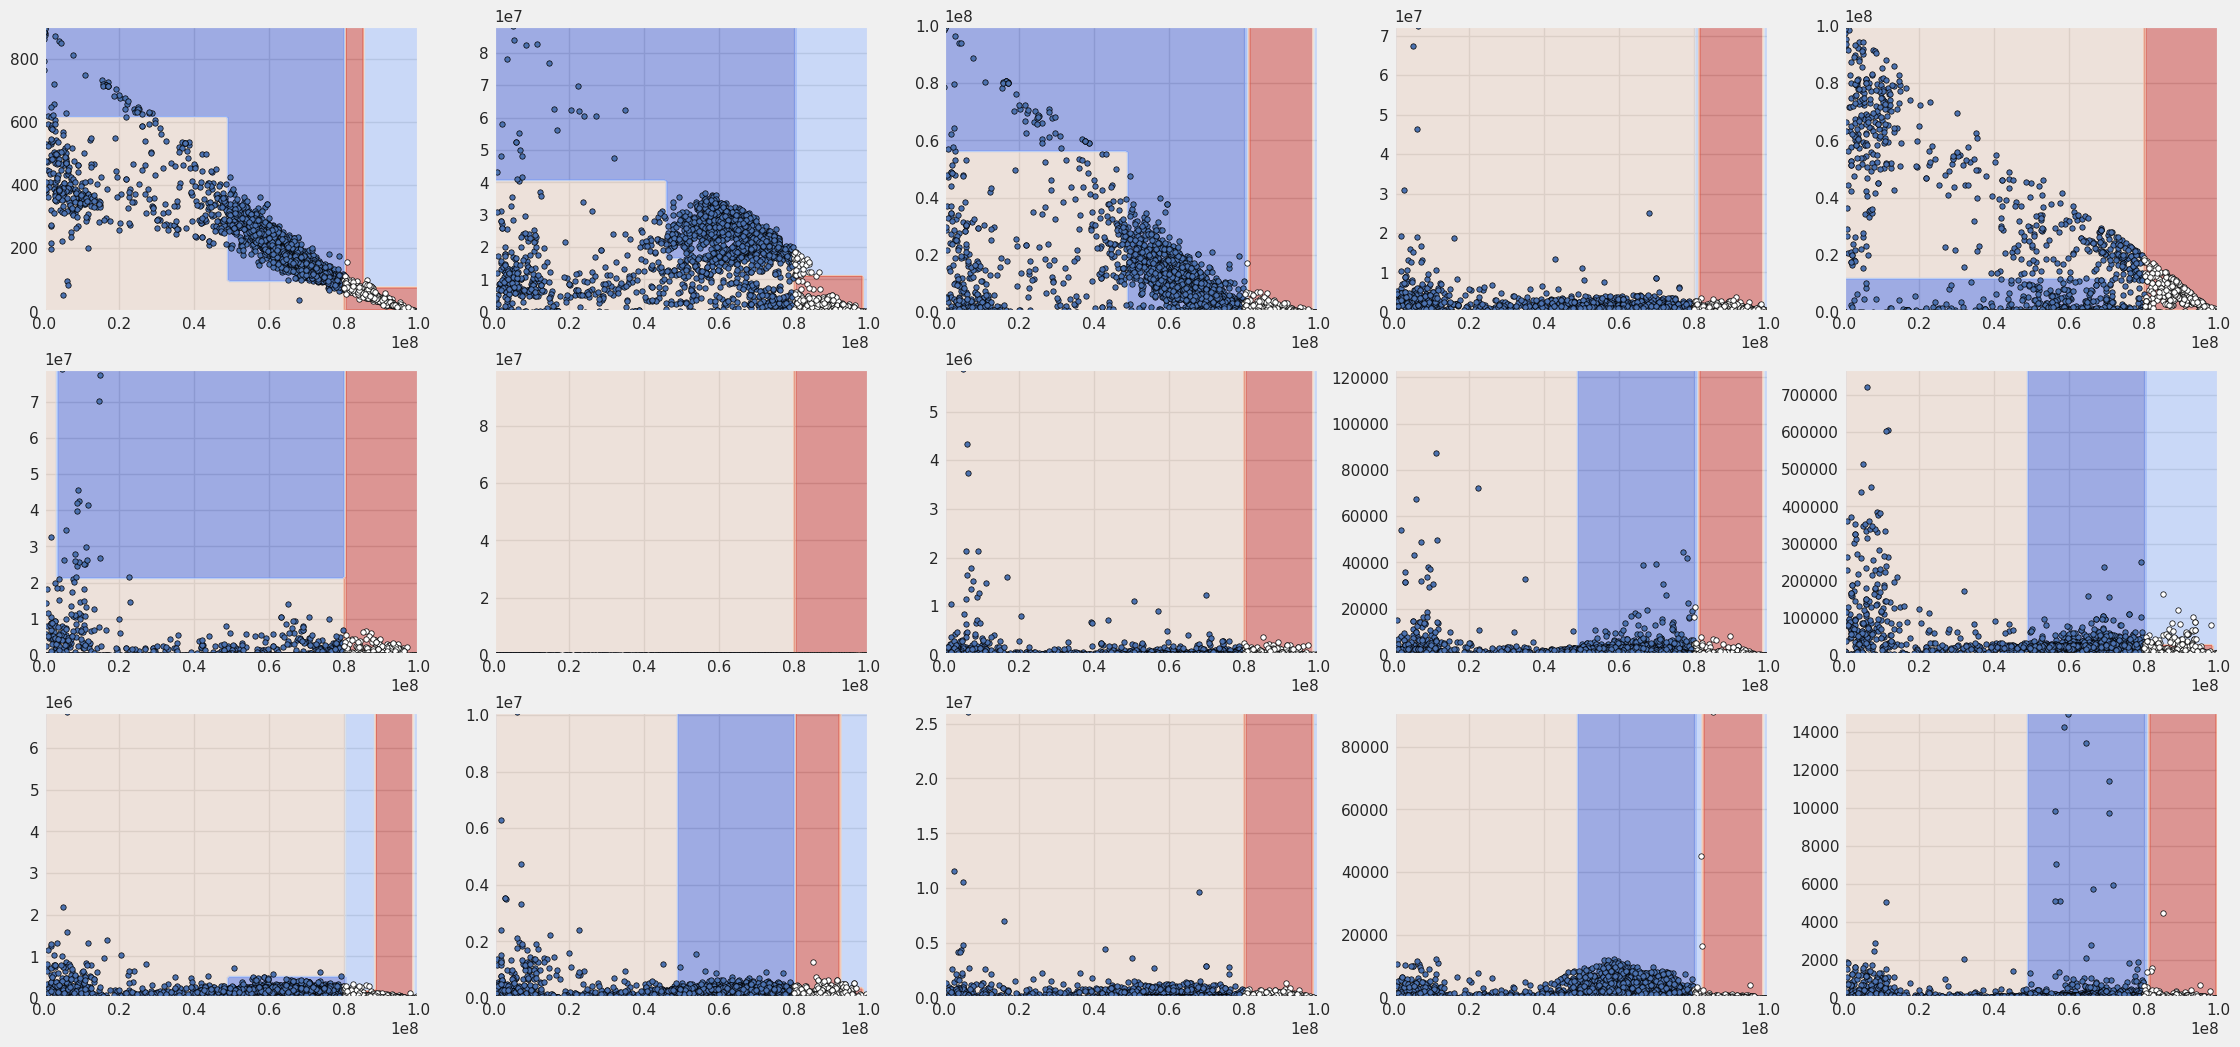

In [ ]:
from itertools import combinations
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Generating all pairs of numbers from 0 to 5
comb = combinations(np.arange(0, 47), 2)

# Using sets to obtain all unique combinations from 0 to 5 pairs
unique_combinations = set(comb) 
print(unique_combinations)

n_classes = 4
color_palette = plt.cm.coolwarm
plot_colors = "bwr" # blue, white and red, same as the coolwarm palette
plot_step = 0.02

plt.figure(figsize=(25, 12))

for pair_idx, pair in enumerate(sorted(unique_combinations)):
    # Only two corresponding features are taken each time
    X_train_cols = X_train[:, pair]

    # Creating and fitting the classifier to train data
    classifier = DecisionTreeClassifier(max_depth=4, 
                                        random_state=42).fit(X_train_cols, y_train)

    # Defining a grid of 5 columns and 3 rows 
    ax = plt.subplot(3, 5, pair_idx + 1)
    # Plotting the pairs decision boundaries
    DecisionBoundaryDisplay.from_estimator(classifier,
                                           X_train_cols,
                                           cmap=color_palette,
                                           response_method="predict",
                                           ax=ax,
                                           alpha = 0.5)

    # Plotting the training points according to y_train class colors
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_train == i)
        plt.scatter(X_train_cols[idx, 0],
                    X_train_cols[idx, 1],
                    c=color,
                    label=data.CLASS[i],
                    cmap=color_palette,
                    edgecolor="black",
                    s=15)

plt.suptitle("Decision surface of decision trees trained on pairs of features", fontsize=14)
plt.legend(loc="lower right");

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay

disp = DecisionBoundaryDisplay.from_estimator(clf, X_test[:, :2] , response_method="predict", alpha=0.7)
disp.ax_.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolor="purple");

**2ой вариант**

In [ ]:
!pip install mlxtend --upgrade --no-deps

In [ ]:
from mlxtend.plotting import plot_decision_regions

fig, ax = plt.subplots(figsize=(10, 8))
plot_decision_regions(X_test, y_test, clf=clf, legend=2);

## **Нормализация признаков и обучение модели на этих данных. Сравнение результата**

* StandardScaler

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

data_ss = data.copy()
#---------
y1 = data_ss['CLASS'].values
#---------
data_ss.drop(columns='CLASS', inplace=True)

data_ss[:] = scaler.fit_transform(data_ss[:])
#---------
X1 = data_ss.loc[:, data_ss.columns !='CLASS'].values
#---------
data_ss.head()

,Water,Energ_Kcal,Protein,Lipid_Tot,Ash,Carbohydrt,Fiber_TD,Sugar_Tot,Calcium,Iron,Magnesium,Phosphorus,Potassium,Sodium,Zinc,Copper,Manganese,Selenium,Vit_C,Thiamin,Riboflavin,Niacin,Panto_Acid,Vit_B6,Folate_Tot,Folic_Acid,Food_Folate,Folate_DFE,Choline_Tot,Vit_B12,Vit_A,Retinol,Alpha_Carot,Beta_Carot,Beta_Crypt,Lycopene,Lut+Zea,Vit_E,Vit_D,Vit_K,FA_Sat,FA_Mono,FA_Poly,Cholestrl,Refuse_Pct
0,-1.242449,2.888612,-0.996484,4.461650,0.132257,-0.809252,-0.477926,-0.488427,-0.248492,-0.466380,-0.543397,-0.644770,-0.651861,0.354966,-0.555111,-0.308948,-0.078782,-0.412699,-0.127578,-0.397895,-0.457737,-0.706700,-0.299406,-0.552567,-0.322592,-0.17649,-0.293491,-0.251959,-0.095037,-0.241937,0.493380,0.787623,-0.077677,0.015814,-0.054164,-0.088688,-0.132603,0.370117,-0.117996,-0.036950,7.459568,2.527172,0.183620,1.502229,-0.409331
1,-1.214828,2.894499,-1.030672,4.283959,-0.032865,-0.706206,-0.477926,-0.488427,-0.253492,-0.461071,-0.561314,-0.644770,-0.606056,0.291096,-0.567065,-0.290554,-0.078624,-0.448352,-0.127578,-0.393956,-0.389268,-0.710918,-0.309787,-0.541879,-0.314761,-0.17649,-0.275828,-0.246510,-0.095037,-0.265347,0.484989,0.787623,-0.073759,-0.006502,-0.005453,-0.088688,-0.118335,0.123564,-0.117996,-0.075583,6.529255,2.359126,0.240644,1.587447,-0.409331
2,-1.750332,3.824633,-1.050615,5.623283,-0.578777,-0.811452,-0.477926,-0.492799,-0.348489,-0.469919,-0.579231,-0.748714,-0.703056,-0.327385,-0.579020,-0.307109,-0.078782,-0.448352,-0.127578,-0.405773,-0.523923,-0.714926,-0.379259,-0.556842,-0.346084,-0.17649,-0.346477,-0.268308,-0.026845,-0.279392,0.647671,0.988576,-0.077677,0.049773,-0.054164,-0.088688,-0.132603,0.494691,-0.117996,-0.011194,9.102321,3.656907,0.312517,1.851622,-0.409331
3,-0.380054,0.745770,0.955106,1.150015,1.143205,-0.725641,-0.477926,-0.456363,2.271424,-0.415061,-0.167140,1.151975,-0.026751,0.890415,0.212984,-0.235370,-0.077354,0.068606,-0.127578,-0.350630,0.336499,-0.501269,0.993416,-0.204161,-0.064180,-0.17649,0.289359,-0.072122,-0.161281,0.003867,0.012102,0.158496,-0.077677,-0.065689,-0.054164,-0.088688,-0.132603,-0.167108,0.051820,-0.110998,2.370860,0.586947,-0.260488,0.309180,-0.409331
4,-0.422296,0.851735,1.129847,1.209457,0.492828,-0.709139,-0.477926,-0.455634,3.001400,-0.393825,-0.149223,1.468757,-0.350084,0.266612,0.195052,-0.264801,-0.076878,0.068606,-0.127578,-0.380171,0.265748,-0.690670,-0.157268,-0.420044,-0.189471,-0.17649,0.006765,-0.159316,-0.161281,0.013231,0.109278,0.281957,-0.077677,-0.063749,-0.054164,-0.088688,-0.132603,-0.164513,0.059906,-0.109388,2.385644,0.707085,-0.263656,0.471094,-0.409331


In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=57)

In [ ]:
clf_ss = KNeighborsClassifier()
clf_ss.fit(X_train1, y_train1)
score = clf_ss.score(X_test1, y_test1)
score

0.8687902919984831

In [ ]:
dict_score['второй вариант (без подбора параметров) с нормализацией StandardScaler']= score

1 0.8828213879408419
2 0.8672734167614714
3 0.8790291998483125
4 0.8767538869927949
5 0.8687902919984831
6 0.8684110731892302
7 0.8672734167614714
8 0.8691695108077361
9 0.8593098217671596
10 0.8668941979522184


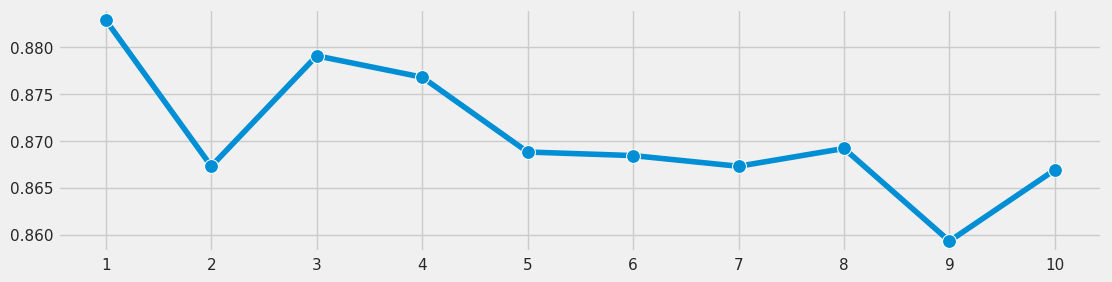

In [ ]:
scores = []
for k in range(1, 11):
    clf = KNeighborsClassifier(k)
    clf.fit(X_train1, y_train1)
    score = clf.score(X_test1, y_test1)
    dict_score[f'2) k={k}'] = score
    print(k, score)
    scores.append(score)
plt.figure(figsize=(12, 3))
sns.lineplot(x=map(str, range(1, 11)), y=scores, marker='o', markersize=10);

* MinMaxScaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

data_ms = data.copy()
#---------
y2 = data_ms['CLASS'].values
#---------
data_ms.drop(columns='CLASS', inplace=True)

data_ms[:] = scaler.fit_transform(data_ms[:])
#---------
X2 = data_ms.loc[:, data_ss.columns !='CLASS'].values
#---------
data_ms.head()

,Water,Energ_Kcal,Protein,Lipid_Tot,Ash,Carbohydrt,Fiber_TD,Sugar_Tot,Calcium,Iron,Magnesium,Phosphorus,Potassium,Sodium,Zinc,Copper,Manganese,Selenium,Vit_C,Thiamin,Riboflavin,Niacin,Panto_Acid,Vit_B6,Folate_Tot,Folic_Acid,Food_Folate,Folate_DFE,Choline_Tot,Vit_B12,Vit_A,Retinol,Alpha_Carot,Beta_Carot,Beta_Crypt,Lycopene,Lut+Zea,Vit_E,Vit_D,Vit_K,FA_Sat,FA_Mono,FA_Poly,Cholestrl,Refuse_Pct
0,0.1587,0.794900,0.009624,0.8111,0.021142,0.0006,0.0,0.000601,0.003259,0.000162,0.002561,0.002420,0.001455,0.016590,0.000990,0.000000,0.000000,0.000522,0.0,0.000214,0.001943,0.000329,0.003188,0.000250,0.000792,0.0,0.001282,0.000510,0.007823,0.001719,0.02499,0.022367,0.00000,0.003684,0.00000,0.0,0.00000,0.015529,0.0000,0.004083,0.537322,0.251180,0.040778,0.069355,0.0
1,0.1672,0.796009,0.005548,0.7830,0.016232,0.0287,0.0,0.000601,0.003123,0.000405,0.001280,0.002420,0.002485,0.015042,0.000550,0.000664,0.000003,0.000000,0.0,0.000299,0.003657,0.000173,0.002812,0.000667,0.001057,0.0,0.001709,0.000680,0.007823,0.000708,0.02468,0.022367,0.00007,0.003148,0.00096,0.0,0.00066,0.009170,0.0000,0.002683,0.474791,0.237474,0.044638,0.072581,0.0
2,0.0024,0.971175,0.003170,0.9948,0.000000,0.0000,0.0,0.000000,0.000543,0.000000,0.000000,0.000302,0.000303,0.000052,0.000110,0.000066,0.000000,0.000000,0.0,0.000043,0.000286,0.000024,0.000290,0.000083,0.000000,0.0,0.000000,0.000000,0.009279,0.000101,0.03069,0.027467,0.00000,0.004500,0.00000,0.0,0.00000,0.018742,0.0000,0.005016,0.647741,0.343319,0.049502,0.082581,0.0
3,0.4241,0.391353,0.242301,0.2874,0.051202,0.0234,0.0,0.005010,0.071700,0.002508,0.029449,0.039020,0.015515,0.029568,0.029247,0.002658,0.000027,0.007564,0.0,0.001241,0.021829,0.007969,0.050116,0.013833,0.009509,0.0,0.015385,0.006121,0.006408,0.012337,0.00721,0.006400,0.00000,0.001725,0.00000,0.0,0.00000,0.001673,0.0021,0.001400,0.195282,0.092939,0.010721,0.024194,0.0
4,0.4111,0.411308,0.263134,0.2968,0.031864,0.0279,0.0,0.005110,0.091526,0.003479,0.030730,0.045473,0.008242,0.014449,0.028587,0.001595,0.000037,0.007564,0.0,0.000599,0.020057,0.000925,0.008348,0.005417,0.005283,0.0,0.008547,0.003401,0.006408,0.012741,0.01080,0.009533,0.00000,0.001772,0.00000,0.0,0.00000,0.001740,0.0022,0.001458,0.196276,0.102738,0.010506,0.030323,0.0


In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=57)

In [ ]:
clf_ms = KNeighborsClassifier()
clf_ms.fit(X_train2, y_train2)
score = clf_ms.score(X_test2, y_test2)
score

0.8828213879408419

In [ ]:
dict_score['третий вариант (без подбора параметров) с нормализацией MinMaxScaler']= score

1 0.8949563898369359
2 0.8740993553280243
3 0.8858551384148654
4 0.8809252938945772
5 0.8828213879408419
6 0.8805460750853242
7 0.8794084186575654
8 0.875616230565036
9 0.8794084186575654
10 0.8801668562760713


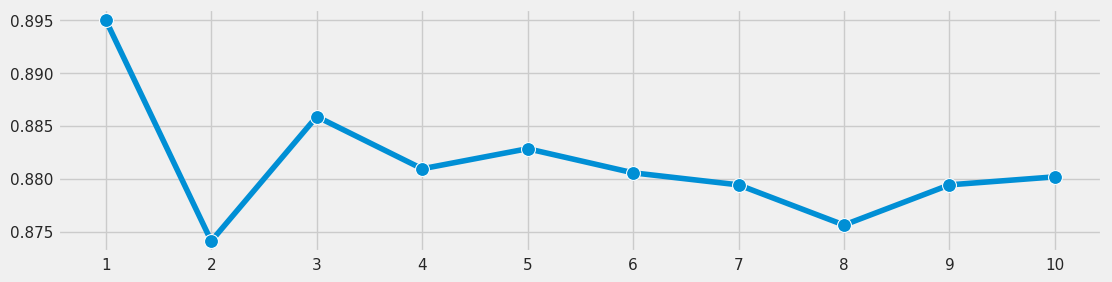

In [ ]:
scores = []
for k in range(1, 11):
    clf = KNeighborsClassifier(k)
    clf.fit(X_train2, y_train2)
    score = clf.score(X_test2, y_test2)
    dict_score[f'3) k={k}'] = score
    print(k, score)
    scores.append(score)
plt.figure(figsize=(12, 3))
sns.lineplot(x=map(str, range(1, 11)), y=scores, marker='o', markersize=10);

In [ ]:
dict_score

{'первый вариант (без подбора параметров)': 0.8953356086461889,
 '1) k=1': 0.9059537353052711,
 '1) k=2': 0.8960940462646947,
 '1) k=3': 0.90064467197573,
 '1) k=4': 0.8976109215017065,
 '1) k=5': 0.8953356086461889,
 '1) k=6': 0.8968524838832006,
 '1) k=7': 0.8904057641259007,
 '1) k=8': 0.8926810769814183,
 '1) k=9': 0.8869927948426242,
 '1) k=10': 0.8869927948426242,
 '1) с метрикой manhattan': 0.9082290481607888,
 '1) k=1 с метрикой manhattan': 0.9086082669700417,
 '1) k=2 с метрикой manhattan': 0.8957148274554418,
 '1) k=3 с метрикой manhattan': 0.907470610542283,
 '1) k=4 с метрикой manhattan': 0.9036784224497535,
 '1) k=5 с метрикой manhattan': 0.9082290481607888,
 '1) k=6 с метрикой manhattan': 0.9051952976867652,
 '1) k=7 с метрикой manhattan': 0.9051952976867652,
 '1) k=8 с метрикой manhattan': 0.9044368600682594,
 '1) k=9 с метрикой manhattan': 0.9032992036405005,
 '1) k=10 с метрикой manhattan': 0.9089874857792947,
 'второй вариант (без подбора параметров) с нормализацией S

## **Подборка гиперпараметров с помощью GridSearchCV**

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'n_neighbors': range (1, 7),
          'weights': ['uniform', 'distance'],
          'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
          'metric': ['l1', 'l2'] 
          }

In [ ]:
best_clf = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params)
best_clf.fit(X_train, y_train)
score = best_clf.score(X_test, y_test)
param = best_clf.best_params_
score, param

(0.9207432688661358,
 {'algorithm': 'auto',
  'metric': 'l1',
  'n_neighbors': 6,
  'weights': 'distance'})

In [ ]:
dict_score[f'GridSearchCV: {param}'] = score

In [ ]:
best_clf1 = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params)
best_clf1.fit(X_train1, y_train1)
score = best_clf1.score(X_test1, y_test1)
param = best_clf1.best_params_
score, param

In [ ]:
dict_score[f'StandardScaler+GridSearchCV: {param}'] = score

In [ ]:
best_clf2 = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params)
best_clf2.fit(X_train2, y_train2)
score = best_clf2.score(X_test2, y_test2)
param = best_clf2.best_params_
score, param

(0.9116420174440653,
 {'algorithm': 'auto',
  'metric': 'l1',
  'n_neighbors': 6,
  'weights': 'distance'})

In [ ]:
dict_score[f'MinMaxScaler+GridSearchCV: {param}'] = score

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
y_clf = clf.predict(X_test)
print(classification_report(y_test, y_clf))

              precision    recall  f1-score   support

           0       0.67      0.12      0.20      1011
           1       0.09      1.00      0.16       163
          10       0.85      0.53      0.65      1009
          11       0.00      0.00      0.00       454

    accuracy                           0.31      2637
   macro avg       0.40      0.41      0.26      2637
weighted avg       0.59      0.31      0.34      2637



In [ ]:
y_best_clf = best_clf.predict(X_test)
print(classification_report(y_test, y_best_clf))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1011
           1       0.88      0.85      0.87       163
          10       0.93      0.91      0.92      1009
          11       0.92      0.96      0.94       454

    accuracy                           0.92      2637
   macro avg       0.91      0.91      0.91      2637
weighted avg       0.92      0.92      0.92      2637



## **Плюсы и минусы метода k-ближайших соседей для классификации в целом и применительно к рассмотренному набору данных**

## **Предварительный отбор признаков и оценка результатов предсказаний, если:**

### оставить только по одному из сильно коррелирующих признаков,

### объединить группу связанных по смыслу признаков в один (например, для витамина A),

### повторно выбирать случайным образом поднабор из нескольких признаков и запоминать лучшие результаты (например, выбирать по 5 или по 7 признаков с помощью random.sample, повторять выбор 100 раз),

 ### использовать методы уменьшения размерности (например, PCA),

### свой вариант отбора и подготовки признаков.

Первый способ был [основан на алгоритме Брона-Кербоша — одном из алгоритмов решения задач теории графов о поиске максимальных клик. Клика — это такой подграф, в котором все вершины попарно соединены друг с другом](https://habr.com/ru/company/akbarsdigital/blog/592493/). Чтобы свести задачу к поиску максимальных клик, построим граф связей для признаков по таким правилам:
* Каждая из вершин графа представляет собой отдельный признак,
* Ребром соединяются только те вершины, которые не являются сильно коррелированными при заданном пороге корреляции.

Если для построенного графа мы сможем найти наибольшую клику, то это и будет решением нашей задачи. Алгоритм Брона-Кербоша находит все максимальные клики, при этом наибольших может быть несколько.

Так как метод применяется для задачи классификации с количественными признаками, то в качестве меры, показывающей связь между признаком и таргетом, предлагается использовать совместную информацию (MI — mutual information).

Для двух клик одинаковой длины, будем считать лучшей ту, для которой сумма MI, вычисленная для всех признаков клики, наибольшая.


На вход алгоритму отбора были поданы:

* 8790 записей для 46 признаков и целевая переменная,
* Порог 0.7 для определения степени корреляции признаков.

Вывод на печать результатов работы алгоритма: слева - размер найденных клик, справа — их количество

=> qliques search...

48 qliques are found:


36    12

38    12

35    12

39     6

37     6

dtype: int64

Task completed in: 0:00:00.002073

Алгоритму Брона-Кербоша удалось отыскать 48 максимальных клик. Размер найденных клик варьировался от 35 до 39, причем клик размера 39 было найдено 6. 

Для выбора оптимальной клики мы использовали значения MI, вычисленные на первом шаге. В результате была выделена единственная клика размера 39, признаки которой обладали следующими свойствами:
* отсутствие мультиколлинеарности;
* наибольший суммарный показатель MI среди всех клик размерности 39.

In [ ]:
data1 =  pd.read_csv('/content/drive/MyDrive/python/data_products.csv')

data1.shape

(8790, 40)

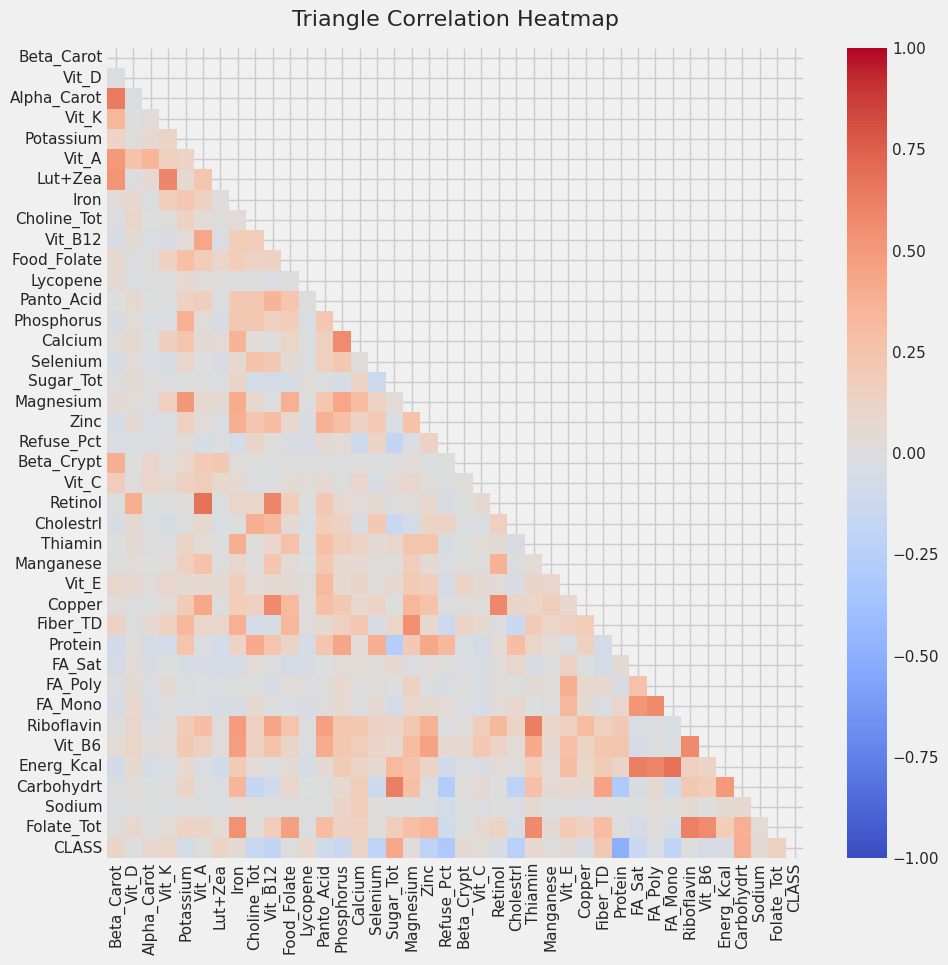

In [ ]:
heatmap = plt.figure(figsize=(10, 10))

mask = np.triu(np.ones(data1.corr().shape), k=0).astype(bool)
heatmap = sns.heatmap(data1.corr(), mask=mask, vmin=-1, vmax=1, annot=False, cmap='coolwarm') 
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':16}, pad=16);

**Отобранные признаки и их кол-во:**

In [ ]:
data1.columns, len(data1.columns)

(Index(['Beta_Carot', 'Vit_D', 'Alpha_Carot', 'Vit_K', 'Potassium', 'Vit_A',
        'Lut+Zea', 'Iron', 'Choline_Tot', 'Vit_B12', 'Food_Folate', 'Lycopene',
        'Panto_Acid', 'Phosphorus', 'Calcium', 'Selenium', 'Sugar_Tot',
        'Magnesium', 'Zinc', 'Refuse_Pct', 'Beta_Crypt', 'Vit_C', 'Retinol',
        'Cholestrl', 'Thiamin', 'Manganese', 'Vit_E', 'Copper', 'Fiber_TD',
        'Protein', 'FA_Sat', 'FA_Poly', 'FA_Mono', 'Riboflavin', 'Vit_B6',
        'Energ_Kcal', 'Carbohydrt', 'Sodium', 'Folate_Tot', 'CLASS'],
       dtype='object'),
 40)

In [ ]:
y = data1['CLASS'].values

X = data1.loc[:, data1.columns !='CLASS'].values

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=53)

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'n_neighbors': range (1, 7),
          'weights': ['uniform', 'distance'],
          'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
          'metric': ['l1', 'l2'] 
          }

In [ ]:
best_clf = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params)
best_clf.fit(X_train, y_train)
score = best_clf.score(X_test, y_test)
param = best_clf.best_params_
score, param

(0.9241562381494122,
 {'algorithm': 'auto',
  'metric': 'l1',
  'n_neighbors': 6,
  'weights': 'distance'})

In [ ]:
dict_score[f'отбор признаков основанный на графовом методе+GridSearchCV+{param}'] = score

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

data_ss = data1.copy()
#---------
y1 = data_ss['CLASS'].values
#---------
data_ss.drop(columns='CLASS', inplace=True)

data_ss[:] = scaler.fit_transform(data_ss[:])
#---------
X1 = data_ss.loc[:, data_ss.columns !='CLASS'].values
#---------

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=57)

clf_ss = KNeighborsClassifier()
clf_ss.fit(X_train1, y_train1)
score = clf_ss.score(X_test1, y_test1)
score

0.8722032612817596

In [ ]:
dict_score[f'отбор признаков основанный на графовом методе+StandardScaler'] = score

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

data_ms = data1.copy()
#---------
y2 = data_ms['CLASS'].values
#---------
data_ms.drop(columns='CLASS', inplace=True)

data_ms[:] = scaler.fit_transform(data_ms[:])
#---------
X2 = data_ms.loc[:, data_ss.columns !='CLASS'].values
#---------
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=57)

clf_ms = KNeighborsClassifier()
clf_ms.fit(X_train2, y_train2)
score = clf_ms.score(X_test2, y_test2)
score

0.8877512324611301

In [ ]:
dict_score[f'отбор признаков основанный на графовом методе+MinMaxScaler'] = score

In [ ]:
best_clf1 = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params)
best_clf1.fit(X_train1, y_train1)
score = best_clf1.score(X_test1, y_test1)
param =  best_clf1.best_params_
score, param

(0.9116420174440653,
 {'algorithm': 'auto',
  'metric': 'l1',
  'n_neighbors': 6,
  'weights': 'distance'})

In [ ]:
dict_score[f'отбор признаков основанный на графовом методе+StandardScaler+GridSearchCV+{param}'] = score

In [ ]:
best_clf2 = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params)
best_clf2.fit(X_train2, y_train2)
score = best_clf2.score(X_test2, y_test2)
param = best_clf2.best_params_
score, param

(0.9177095183921122,
 {'algorithm': 'auto',
  'metric': 'l1',
  'n_neighbors': 6,
  'weights': 'distance'})

In [ ]:
dict_score[f'отбор признаков основанный на графовом методе+MinMaxScaler+GridSearchCV+{param}'] = score

In [ ]:
dict_score

{'первый вариант (без подбора параметров)': 0.8953356086461889,
 '1) k=1': 0.9059537353052711,
 '1) k=2': 0.8960940462646947,
 '1) k=3': 0.90064467197573,
 '1) k=4': 0.8976109215017065,
 '1) k=5': 0.8953356086461889,
 '1) k=6': 0.8968524838832006,
 '1) k=7': 0.8904057641259007,
 '1) k=8': 0.8926810769814183,
 '1) k=9': 0.8869927948426242,
 '1) k=10': 0.8869927948426242,
 '1) с метрикой manhattan': 0.9082290481607888,
 '1) k=1 с метрикой manhattan': 0.9086082669700417,
 '1) k=2 с метрикой manhattan': 0.8957148274554418,
 '1) k=3 с метрикой manhattan': 0.907470610542283,
 '1) k=4 с метрикой manhattan': 0.9036784224497535,
 '1) k=5 с метрикой manhattan': 0.9082290481607888,
 '1) k=6 с метрикой manhattan': 0.9051952976867652,
 '1) k=7 с метрикой manhattan': 0.9051952976867652,
 '1) k=8 с метрикой manhattan': 0.9044368600682594,
 '1) k=9 с метрикой manhattan': 0.9032992036405005,
 '1) k=10 с метрикой manhattan': 0.9089874857792947,
 'второй вариант (без подбора параметров) с нормализацией S

---

Второй способ был основан на поиске пар признаков, которые сильно коррелируют, а затем искались группы признаков, которые коррелируют с признаками в паре. К каждой группе применялся PCA.

Пары признаков, которые сильно коррелируют (|x|> 0.7)

In [ ]:
import numpy as np

corr_matrix = data.corr().abs()
high_corr_var=np.where(corr_matrix>0.8)
high_corr_var=[(corr_matrix.index[x], corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
high_corr_var, len(high_corr_var)

([('Water', 'Energ_Kcal'),
  ('Energ_Kcal', 'Lipid_Tot'),
  ('Lipid_Tot', 'FA_Mono'),
  ('Ash', 'Sodium'),
  ('Folate_Tot', 'Folic_Acid'),
  ('Folate_Tot', 'Folate_DFE'),
  ('Folic_Acid', 'Folate_DFE')],
 7)

**Отобранные признаки и их кол-во:**

In [ ]:
data2.columns, len(data2.columns)